# Cortical Magnification in Human Visual Cortex Parallels Task Performance around the Visual Field

Noah C. Benson$^{1,2,3,*}$, Eline Kupers$^{1,2}$, Antoine Barbot$^{1,2}$, Marisa Carasco$^{1,2}$, Jonathan Winawer$^{1,2}$

$^1$Department of Psychology and $^2$Center for Neural Sciences, New York University, New York, NY 10031  
$^3$eScience Institute, University of Washington, Seattle, WA 98195  
$^*$ To whom correspondences should be addressed; email: [nben@uw.edu](mailto:nben@uw.edu)

## Introduction

This Jupyter notebook accompanies the manuscript "Cortical Magnification in Human Visual Cortex Parallels Task Performance around the Visual Field" by Noah C. Benson, Eline R. Kupers, Antoine Barbot, Marisa Carrasco, and Jonathan Wianwer. The notebook contains source code and documentation of the analyses performed in this project. This manuscript can be found on [bioaR$\chi$i$\nu$](https://www.bioarxiv.org/), manuscript ID [BIORXIV/2020/268383](https://www.bioarxiv.org/).

Explicitly, this notebook contains source code for analyzing the dataset provided on OSF and for generating Figures 2 and 3C of the manuscript. Figures 1 and 3 were primarily generated using Matlab and thus are not included in thiis notebook. Additionally, all code used to generate the dataset is included in the [performance fields github repository](https://github.com/noahbenson/performance-fields/) as well as in the [neuropythy library](https://github.com/noahbenson/neuropythy) as a dataset.

The data on the [OSF site](https://osf.io/5gprz/) for the manuscript is automatically downloaded and managed by this notebook. You should not need to handle these details, but it is suggested that you set neuropythy's `DATA_ROOT` environment variable so that it knows where to save cache files. This can be done by running `import neuropythy as ny` then `ny.config['data_root'] = '/my/data/path'`.

## Configuration

Here, we configure various paths and settings that are used throughout the rest of the notebook.

In [1]:
# The directory to put the figures and output images in. If this is None,
# then no figures will be exported.
figures_path = '/data/performance-fields/figures'

# If you have obtained the Barbot et al. (2020) data for use in some of
# the panels plotted below, its path should be here (if this is None,
# that's fine--there will just be error messages when you try to use it.)
barbot2020_path = '/data/performance-fields/supp/barbot_xue_carrasco_2020.mat'
#barbot2020_path = None

# The colors we will use in the plots for different boundaries.
colors = {'vertical':   (0.7, 0.2, 0.7),
          'horizontal': (0.6, 0.6, 0.6),
          'dorsal':     (0.8, 0.2, 0.1),
          'ventral':    (0.1, 0.5, 0.8),
          'M':          (0.4, 0.9, 0.5),
          'F':          (0.7, 0.4, 1.0)}

## Initialization

In this section, we import and configure libraries and prepare various data for use in the rest of the notebook.

### Libraries

In [4]:
# Some standard libraries:
import os, sys, six, h5py, pandas
import numpy           as np
import scipy           as sp
import scipy.stats     as stats
import pyrsistent      as pyr
from   functools   import reduce
from   importlib   import reload

# Import nearopythy and pimms (related data-structures library)
import pimms
import neuropythy as ny

# This library is included in neuropythy, but we want to explicitly
# include the version from the performance-fields repository here.
# Everything in this notebook *should* work without these lines.
# We assume that this notebook is being run from the directory that
# contains it.
if 'visual_performance_fields' not in ny.data:
    dirname = os.path.join(os.getcwd(), '..')
    sys.path.insert(0, dirname)
    import visual_performance_fields

#### Graphics Libraries and Configuration

These two cells import and configure matplotlib and pyplot for graphics/plotting. Usually these two cells would go in a single cell, but due to a bug in (some versions of) matplotlib, all matplotlib.rc configurations must go in a separate cell after the '%matplotlib inline'-type magic codes.

In [5]:
# Graphics libraries:
import ipyvolume         as ipv
import matplotlib        as mpl
import matplotlib.pyplot as plt
import matplotlib.tri    as tri
import seaborn           as sns
# Matplotlib and Graphics Configuration (more in next 2 cells due
# to matplotlib bug that prevents them from working when together)

In [6]:
%gui qt
%matplotlib inline

In [7]:
font_data = {'family':'sans-serif',
             #'sans-serif':['HelveticaNeue','Helvetica Neue','Helvetica','Arial'],
             'sans-serif':['HelveticaNeue','Helvetica','Arial'],
             'size': 10,
             'weight': 'light'}
mpl.rc('font',**font_data)
# we want relatively high-res images, especially when saving to disk.
mpl.rcParams['figure.dpi'] = 72*2
mpl.rcParams['savefig.dpi'] = 72*4

#### Warnings

In general, we want warnings to be treated as errors, but there are a few warnings known to arise from modules that we have no control over (e.g., a FutureWarnings from scipy about deprecated array indexing). These we explicitly ignore.

In [8]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning,
                        module='scipy.stats',
                        message='Using a non-tuple sequence for multidimensional.*')

### Utility Functions

These cells contain utility and graphical functions for use with the data loaded above and the plots produced below.

---

**`line_quantiles_plot`**

This function plots boxes and lines for quantile plots and is used later in this notebook to construct figures.

In [9]:
# Utility functions for graphics
def line_quantiles_plot(xs, ys, quantiles=0.25, color='k', line=True, axes=None, alpha=None):
    '''
    line_quantiles_plot(xs, ys) plots the line specified by the vector xs and the median
      of each row of the ys matrix. The 0.25 and 0.75 quantiles are also plotted as
      semi-transparent regions around the median line.
    
    The following options may be provided (listed in argument order):
      * quantiles (default: 0.25) specifies the quantiles to plot; quantiles are
        plotted with higher alpha when they are closer to 0.5; if this is a list or
        tuple, then the quantiles plotted are unique(min([quantiles, 1-quantiles]));
        quantile regions are always plotted symmetrically around the median, so either
        0.25 or 0.75 will result in a quantile region from quantile 0.25 to 0.75.
      * color (default: 'k') specifies the color of the plot.
      * line (default: True) specifies whether to plot the median line.
      * axes (default: None) specifies the axes on which to plot.
      * alpha (default: None) specifies the alpha to use in the shaded regions; if None
        then uses 1/n where n is the number of quantiles requested.
    '''
    import matplotlib.pyplot as plt
    # parse axes
    axes = plt.gca() if axes is None else axes
    # parse quantiles
    quantiles = np.asarray(quantiles)
    if line:
        if len(quantiles.shape) == 0: quantiles = np.asarray([quantiles, 0.5])
        else: quantiles = np.concatenate([quantiles, [0.5]])
    quantiles = np.unique(np.round(np.min([quantiles, 1-quantiles], axis=1), 6))
    # parse alpha
    if alpha is None: 
        q = np.setdiff1d(quantiles, [0.5])
        alpha = 1.0 / (1 + len(q))
    # turn plot color into an rgba
    color = matplotlib.colors.to_rgba(color)
    if len(color) == 3: color = np.concatenate([color, [1.0]])
    # see if ys needs to be transposed
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    if len(ys.shape) != 2: raise ValueError('ys must be a matrix')
    elif ys.shape[0] != len(xs):
        if ys.shape[1] == len(xs): ys = ys.T
        else: raise ValueError('shape of ys does not match length of xs')
    # get the quantile values
    percentiles = 100.0 * quantiles
    qvals_lo = np.transpose([np.percentile(yrow, percentiles) for yrow in ys])
    qvals_hi = np.transpose([np.percentile(yrow, 100 - percentiles) for yrow in ys])
    # make polygons
    polys = [(np.concatenate([(xs, vlo), np.fliplr([xs, vhi])], axis=1)
              if q != 0.5 else
              np.asarray([xs, vlo]))
             for (q,vlo,vhi) in zip(quantiles, qvals_lo, qvals_hi)]
    ims = []
    for (q,(x,y)) in zip(quantiles, polys):
        rgba = np.array(color)
        if q == 0.5:
            ims.append(axes.plot(x, y, c=rgba))
        else:
            rgba *= (1, 1, 1, alpha)
            im = axes.fill(x,y)
            matplotlib.pyplot.setp(im, facecolor=rgba)
            ims.append(im)
    return tuple(ims)

---

**`DROI_cortex_plot()`**

This function can make either 2D or 3D plots of the subject distance-based regions of interest (DROIs). The surface argument may be the name of a surface or 'flatmap' for a 2D plot.

In [10]:
# We use the standard colors for these ROI plots.
roi_surface_colors = colors
# The function itself.
def DROI_cortex_plot(sid, h, para, rois=None, surface='very_inflated', figure=None, axes=None,
                     lines={'horizontal':'white','vertical':'black'}):
    '''
    DROI_cortex_plot(sid, h, boundary) plots the given subject and hemisphere with DROIs
      for the given boundary colored. The boundary should be 'vertical', 'horizontal',
      'ventral', or 'dorsal'.
    '''
    hem = data.subjects[sid].hemis[h]
    if surface == 'flatmap': msh = ny.to_flatmap('occipital_pole', hem)
    else: msh = hem.surface(surface)
    va = msh.prop('inf_visual_area')
    ec = msh.prop('inf_eccentricity')
    pa = msh.prop('inf_polar_angle')
    if pimms.is_str(para) and para in roi_surface_colors: para = [para]
    if pimms.is_vector(para, str):
        if rois is None: rois = data.DROI_details[sid][h]
        clrs = np.zeros([msh.vertex_count, 3])
        for p in para:
            c = np.asarray(roi_surface_colors[p])
            rd = rois[p]
            angbins = list(reversed(sorted(rd.keys())))
            nbins = len(angbins)
            for (ii,ang) in enumerate(angbins):
                cc = c * (1 - ii/nbins) + np.ones(3)*(ii/nbins)
                jj = rd[ang]['indices']
                if len(jj) > 0:
                    clrs[msh.tess.index(jj),:] = cc
        alpha = np.sum(clrs, axis=1) > 0
        clrs = np.hstack([clrs, np.reshape(alpha, (-1,1))])
        mask = None
    else:
        mask = ('prf_variance_explained', 0.04, 1)
        clrs = ny.graphics.core.cortex_plot_colors(msh, color=para, mask=mask)
    # Okay, make the figure:
    if ny.is_flatmap(msh):
        if axes is not None: f = axes
        elif figure is None: f = plt.gca()
        else: f = figure
        ny.cortex_plot(msh, axes=f, color=clrs, mask=mask)
    else:
        f = ipv.figure(width=800, height=450) if figure is None else figure
        ny.cortex_plot(msh, figure=f, color=clrs, mask=mask)
    # Draw the lines:
    if pimms.is_str(lines): lines = ['lines']
    if pimms.is_vector(lines): lines = {ln:'black' for ln in lines}
    if lines is None: lines = {}
    lines = {k:v for (k,v) in six.iteritems(lines) if k in roi_surface_colors}
    if 'vertical' in lines:
        c = lines['vertical']
        if 'dorsal' not in lines: lines['dorsal'] = c
        if 'ventral' not in lines: lines['ventral'] = c
        del lines['vertical']
    (u,v) = msh.tess.indexed_edges
    vnorms = np.zeros((2,msh.vertex_count)) if ny.is_flatmap(msh) else msh.vertex_normals
    for (k,clr) in six.iteritems(lines):
        ww = np.zeros(msh.vertex_count)
        if k == 'horizontal':
            ww[(pa >  90) & (va == 1)] = 1
            ww[(pa <= 90) & (va == 1)] = -1
        elif k == 'ventral':
            ww[(pa < 90) & (va == 1)] = 1
            ww[(pa < 90) & (va == 2)] = -1
        elif k == 'dorsal':
            ww[(pa > 90) & (va == 1)] = 1
            ww[(pa > 90) & (va == 2)] = -1
        else: raise ValueError('bad line key: %s' % (k,))
        ww[(ec > 8) | (ec < 0.4)] = 0
        ee = np.where(ww[u]*ww[v] == -1)[0]
        x = np.mean([msh.coordinates[:,u[ee]], msh.coordinates[:,v[ee]]], axis=0)
        nrms = np.mean([vnorms[:,u[ee]], vnorms[:,v[ee]]], axis=0)
        x += 0.5*nrms
        if ny.is_flatmap(msh):
            f.scatter(x[0], x[1], c=clr, s=0.5)
        else:
            ipv.scatter(x[0], x[1], x[2], color=clr, size=0.5, marker='sphere', figure=f)
    return f

---

**`DROI_box_plot()`**

This function can be used to generage box-plots with whiskers that represent the surface area data.

In [11]:
def DROI_box_plot(x, ys, color, ax, scale=0.01, boxwidth=1,
                  bootstraps=1000, zorder=1, boxes=True, ci=68):
    '''
    Given x value, y values, a color, and an axes object, makes a box plot
    of the data on that axes object.
    '''
    boxhwidth = boxwidth * 0.5
    ys = ys[np.isfinite(ys)] * scale
    n = len(ys)
    ypctls = np.percentile(ys, [2.5, 25, 50, 75, 97.5])
    ii0 = np.arange(n)
    mdsem = np.std([np.percentile(ys[ii], 50)
                    for _ in range(bootstraps)
                    for ii in [np.random.choice(ii0, n)]])
    if ci == 95:   mdsem *= 1.96
    elif ci != 68: raise ValueError('ci must be 68 or 95')
    y = ypctls
    clr = np.array(colors[color] if pimms.is_str(color) else color)
    if boxes:
        ps = ax.plot([x,x], y[[0,-1]], 'k-', lw=0.5)
        for p in ps: p.set_zorder(-zorder)
        rect = plt.Rectangle([x-boxhwidth, y[1]], boxwidth, (y[3]-y[1]),
                             fill=True, edgecolor=clr, linewidth=0.75,
                             facecolor=(1 - 0.5*(1 - clr)), zorder=zorder)
        ax.add_patch(rect)
        ps1 = ax.plot([x-boxhwidth, x+boxhwidth], [y[2], y[2]], '-', lw=0.75, c=clr)
        for p in ps1: p.set_zorder(zorder + 1)
    ps2 = ax.plot([x, x], [y[2]-mdsem, y[2]+mdsem], '-', lw=0.75, c=clr)
    for p in ps2: p.set_zorder(zorder + 1)
    return y

---

**`DROI_quant_plot()`**

The `DROI_quant_plot()` function is used for plotting the surface-area data on a set of axes. It is similar to the box-plot function above and is used in the surface-area plotting section below.

In [12]:
def DROI_quant_plot(para, axes=None, dx=0, zorder=1, cumulative=True, ci=68,
                    boxwidth=1, color=None, angles=None, boxes=False,
                    summary=None, quant='surface_area_mm2'):
    '''
    DROI_quant_plot() can be used to plot the quantiles and median ± IQRs of the
    cumulative surface areas of the DROIs with increasing polar angle strip
    width.
    '''
    boxhwidth = boxwidth * 0.5
    if color is None: color = colors[para]
    if not boxes and tuple(color) == (0.6,0.6,0.6): color = (0.3,0.3,0.3)
    if angles in [None,Ellipsis]: angles = data.roi_angles
    ax = plt.gca() if axes is None else axes
    angles = np.asarray(angles)
    # unless we are plotting cumulative ROIs, fix the data to be non-cumulative
    if summary is None: summary = data.DROI_summary
    ys = np.asarray(summary[para][quant])
    if not cumulative:
        (cum,yr) = (0, [])
        for yy in ys:
            yr.append(yy - cum)
            cum = yy
        ys = yr
    # Start by making the boxes...
    yy = []
    for (x,ys) in zip(angles, ys):
        ys = DROI_box_plot(x + dx, ys, color, ax, scale=0.01, zorder=zorder,
                           boxes=boxes, ci=ci)
        yy.append(ys)
    yy = np.transpose(yy) # will be 5 x n where the 5 are (2.5%, 25%, 50%, 75%, 97.5%)
    (y25,y50,y75) = yy[1:-1]
    # we need to make trend lines/shaded regions
    deg = 4
    for (alpha, mn, mx) in zip([0.15, 0.3], [0, 1], [-1, -2]):
        if boxes and mn == 0: continue
        (t25,t50,t75) = [np.polyfit(angles + dx, y, deg) for y in yy[[mn,2,mx]]]
        # we want to sample at these x's...
        x = np.linspace(angles[0]+dx, angles[-1]+dx, 200)
        xmtx = np.transpose([x**q for q in reversed(range(deg+1))])
        # first do the shaded region...
        y = np.concatenate([np.dot(xmtx, t75), np.flip(np.dot(xmtx,t25))])
        tclr = np.concatenate([color, [alpha]])
        #print(quant, para, tclr)
        pgon = plt.Polygon(np.transpose([np.concatenate([x, np.flip(x)]), y]),
                           fill=True, edgecolor=None, linewidth=None, zorder=-zorder-2,
                           facecolor=tclr)
        ax.add_patch(pgon)
    # and make a dotted line...
    ps = ax.plot(x, np.dot(xmtx, t50), ':' if boxes else '-', c=color, lw=1)
    for p in ps: p.set_zorder(-zorder)
    # That's all!
    return ax

---

**`DROI_diff_plot()`**

The `DROI_diff_plot` function is used to plot asymmetries on a set of axes, much like with the two functions above.

In [13]:
def DROI_diff_plot(para1, para2, axes=None, dx=0, zorder=1,
                   color=None, angles=None, cumulative=False,
                   bootstraps=1000, ci=68, quant='surface_area_mm2'):
    '''
    DROI_diff_plot() can be used to produce a line-plot with error bards of the
    difference (asymmetry) between two paradigms, in terms of increasing polar
    angle strip width.
    '''
    if color is None: color = np.array([0,0.5,0,1])
    ax = plt.gca() if axes is None else axes
    if angles in [None,Ellipsis]: angles = data.roi_angles
    angles = np.asarray(angles)
    # depending on if we're doing a cumulative or instantaneous plot,
    # we gather different sets of y-values
    ys1 = np.asarray(data.DROI_summary[para1][quant])
    ys2 = np.asarray(data.DROI_summary[para2][quant])
    if not cumulative:
        res = []
        for ys in (ys1,ys2):
            (cum,yr) = (0, [])
            for yy in ys:
                yr.append(yy - cum)
                cum = yy
            res.append(yr)
        (ys1,ys2) = [np.asarray(u) for u in res]
    # okay, now do the plotting...
    yln = []
    for (x,y1,y2) in zip(angles+dx, ys1, ys2):
        ys = []
        n = len(y1)
        for bs in range(bootstraps):
            bsii = np.random.choice(np.arange(n), n)
            yy1 = y1[bsii]
            yy2 = y2[bsii]
            mu = np.nanmean([yy1, yy2], axis=0)
            dy = yy1 - yy2
            #kk = mu > 0
            #(mu,dy) = (mu[kk], dy[kk])
            ys.append(np.nanmedian(dy / mu * 100))
        (yl,y,yu) = np.percentile(ys, [2.5,50,97.5] if ci == 95 else [16,50,84])
        ax.plot([x, x], [yl, yu], '-', c=color, lw=0.5)
        ax.plot(x, y, '.', c=color, ms=1)
        yln.append(y)
    ax.plot(angles+dx, yln, '-', color=color, lw=0.5)
    return ax

---

**`redraw_axes()`**

The `redraw_axes()` function is used to make outward facing floating spines for your axes.

In [ ]:
def redraw_axes(ax, xlim, ylim, xticks, yticks):
    '''
    redraw_axes(axes, xlim, ylim, xticks, yticks) yileds the given axes after
      setting the given xlim and ylim, setting the given xticks and yticks,
      clearing all the spines, and drawing outward-spine floating axes.    
    '''
    for sp in ax.spines.values():
        sp.set_visible(False)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.plot([xlim[0], xlim[0]], [yticks[0], yticks[-1]], 'k-', lw=1)
    ax.plot([xticks[0], xticks[-1]], [ylim[0], ylim[0]], 'k-', lw=1)
    return ax

---

**`load_barbot2020_data()`**

This function loads the external dataset from Barbot et al. (2020) to which surface area data are compared in this project.

In [14]:
def load_barbot2020_data(filename=barbot2020_path, reload=False):
    '''
    Load and return the data from Barbot et al. (2020). If the filename
    argument is given, then it must be the MAT file containing the data;
    otherwise the directory 'supp/BarbotXueCarrasco.mat' in the data
    directory is used.
    '''
    if filename is None:
        raise ValueError("No barbot2020_path found")
    filename = os.path.abspath(filename)
    if reload or filename not in load_barbot2020_data.cache:
        from scipy.io import loadmat
        pp_raw = loadmat(filename)
        pp_dat = pp_raw['dat']
        pp_dat = {nm: pp_dat[nm][0,0].T for nm in pp_dat.dtype.names}
        behavior_mtx = 10**pp_dat['sens75']
        behavior_mean = np.mean(behavior_mtx, axis=1)
        behavior_sem = np.sqrt(np.var(behavior_mtx, axis=1) / behavior_mtx.shape[1])
        result = {'raw': pp_raw, 'matrix': behavior_mtx,
                  'mean': behavior_mean, 'sem': behavior_sem,
                  'angles': np.flip(np.arange(0,181,15))}
        load_barbot2020_data.cache[filename] = result
    return load_barbot2020_data.cache[filename]
load_barbot2020_data.cache = {}

---

**`corr()`**, **`icc()`**, and **`heritability()`**

These functions calculate the correlation coefficient and the intraclass correlation coefficients of two vectors; they can be given boostrap and confidence-level parameters to obtain confidence intervals as well.

In [52]:
def corr(x, y=None, bootstraps=None, confidence=95):
    '''
    corr(x, y) yields the correlation value r of the values in x and y. It
      excludes any comparison of nans (but not infinities). 
    corr(xy) is equivalent to corr(xy[0], xy[1]) if xy is a (2xN) matrix and
      equivalent to corr(xy[:,0], xy[:,1]) if not.
    '''
    x = np.asarray(x)
    if y is None:
        if x.shape[0] != 2: x = x.T
        (x, y) = x
    else:
        y = np.asarray(y)
    if bootstraps is None:
        ii = (~np.isnan(x)) & (~np.isnan(y))
        return np.corrcoef(x[ii], y[ii])[0,1]
    n = len(x)
    rng = np.arange(n)
    rs = [corr(x[ii], y[ii])
          for _  in range(bootstraps)
          for ii in [np.random.choice(rng, n)]]
    lev = 0.5 * (100 - confidence)
    return tuple(np.percentile(rs, [lev, 50, 100-lev]))    

def icc(x, y=None, bootstraps=None, confidence=95):
    '''
    icc(xy) yields the intraclass correlation of the matrix xy; if xy has 2 rows,
      then it as assumed to be a 2 x n matrix; otherwise it must be an n x 2 matrix.
    icc(x, y) is equivalent to icc([x,y]).
    
    The optional argument bootstrap may be set to a positive integer; in this case
    the return value is (r_lb, r, r_up) where r is the median correlation across
    all bootstraps and r_lb and r_ub are the 2.5- and 97.5-percentile values.
    When bootstrap is given, the argument confidence (default: 95) determines the
    confidence boundary used for r_lb and r_ub.
    '''
    x = np.asarray(x if y is None else [x, y])
    if x.shape[0] != 2: x = x.T
    if bootstraps is not None:
        n = x.shape[1]
        rng = np.arange(n)
        rs = [icc(x[:,np.random.choice(rng, n)]) for _ in range(bootstraps)]
        lev = 0.5 * (100 - confidence)
        return tuple(np.percentile(rs, [lev, 50, 100-lev]))
    x = x[:,np.isfinite(np.sum(x, axis=0))]
    mu0 = np.mean(x, axis=0)
    ms0 = np.sum((x - mu0)**2) / x.shape[1]
    ms1 = np.var(mu0, ddof=1)*2
    den = ms0 + ms1
    return np.nan if np.isclose(den, 0, atol=1e-12) else (ms1 - ms0) / den

def heritability(mzmtx, dzmtx, bootstraps=None, confidence=95, method='falconer'):
    '''
    heritability(mzmtx, dzmtx) yields Falconer's heritability index, h^2.
    
    The following optional arguments may be povided:
      * bootstraps (default: None) may be set to a positive integer; in this case
        the return value is (h2_lb, h2, h2_up) where h2 is the median heritability
        across all bootstraps and h2_lb and h2_ub are the 2.5- and 97.5-percentile
        values. If 0 or None are given, then a straightforward heritability
        calculation is performed and only the heritability number is returned.
      * confidence (default: 95) determines the confidence boundary used for h2_lb
        and h2_ub when bootstrap is not None.    
      * method (default: 'falconer') may specify the heritability calculation to
        use. By default this uses Falcone's formula (2*(Rmz - Rdz)), but the
        'jacard' formula ((Rmz - Rdz) / (1 - Rdz)) can also be used.
    '''
    if bootstraps is None:
        rmz = icc(mzmtx)
        if np.isnan(rmz): return np.nan
        rdz = icc(dzmtx)
        if np.isnan(rdz): return np.nan
        method = method.lower()
        if method in ['falconer','f']: return 2 * (rmz - rdz)
        elif method in ['jacard', 'j']:
            if np.isclose(rdz, 1): return np.nan
            else: return (rmz - rdz) / (1 - rdz)
        else: raise ValueError('Unknown heritability method: %s' % (method,))
    else:
        mz = np.asarray(mzmtx)
        dz = np.asarray(dzmtx)
        if mz.shape[0] != 2: mz = mz.T
        if dz.shape[0] != 2: dz = dz.T
        mzn = mz.shape[1]
        dzn = dz.shape[1]
        (mzrng,dzrng) = [np.arange(n) for n in (mzn,dzn)]
        n = mzn + dzn
        choices = [(k_tt, k_ii)
                   for (k_tt,rng) in enumerate([mzrng, dzrng])
                   for k_ii in rng]
        choices = np.asarray(choices)
        chrng = np.arange(len(choices))
        h2s = []
        for bsno in range(bootstraps):
            ch = choices[np.random.choice(chrng, n)]
            (mzch,dzch) = ([],[])
            for (k_tt,k_ii) in ch:
                if k_tt == 0: mzch.append(mz[:,k_ii])
                else:         dzch.append(dz[:,k_ii])
            h2s.append(heritability(mzch, dzch, method=method))
        lev = 0.5 * (100 - confidence)
        return tuple(np.percentile(h2s, [lev, 50, 100-lev]))

### Declare the Dataset.

The novel dataset of surface area measurements.

In [15]:
# We grab thisi dataset from neuropythy, which manages it.
data = ny.data['visual_performance_fields']

The behavioral data to which we compare. This is declared as a lazy-map; the advantage of this is that if the path has been declared as `None` (above), then this will not error out until you try to use it, and if you don't use it, it won't ever load the data.

In [16]:
barbot2020_data = pimms.lmap({'mean':   (lambda:load_barbot2020_data()['mean']),
                              'sem':    (lambda:load_barbot2020_data()['sem']),
                              'matrix': (lambda:load_barbot2020_data()['matrix']),
                              'angles': (lambda:load_barbot2020_data()['angles']),                              
                              'raw':    (lambda:load_barbot2020_data()['raw'])})

### Regenerating the Dataset

If for some reason you want to regenerate the dataset from the source data, the following code-block could be used.

```python
import neuropythy as ny
import pandas

# Get the VPF dataset.
data = ny.data['visual_performance_fields']

# The filename to which we save the regenerated table of DROIs.
DROI_filename = '/data/performance-fields/DROI_table.csv'

if not os.path.isfile(DROI_filename):
    # nprocs here is the number of processes to use; it is recommended
    # that this be greater than 1 in order to speed up the processing,
    # but also to make sure that the memory bloat required to load and
    # process all the subjects happens in separate processes that then
    # exit at the end of their calculations.
    DROI_tables = data.generate_DROI_tables(nprocs=4)
    DROI_table = pandas.concat(list(DROI_tables.values()))
    ny.save(DROI_filename, DROI_table)
else:
    DROI_table = ny.load(DROI_filename)

DROI_summary = type(data).generate_DROI_summary(DROI_table)
```

## Plots and Analyses

### Distance-based ROI Surface Areas

This section plots the distance-based ROI surface areas for each of the angle-wedges in increasing order. This is the primary figure of the paper regarding cortical surface area. This first cell sets up a few functions that construct various components of the plots such as the individual box-plots.

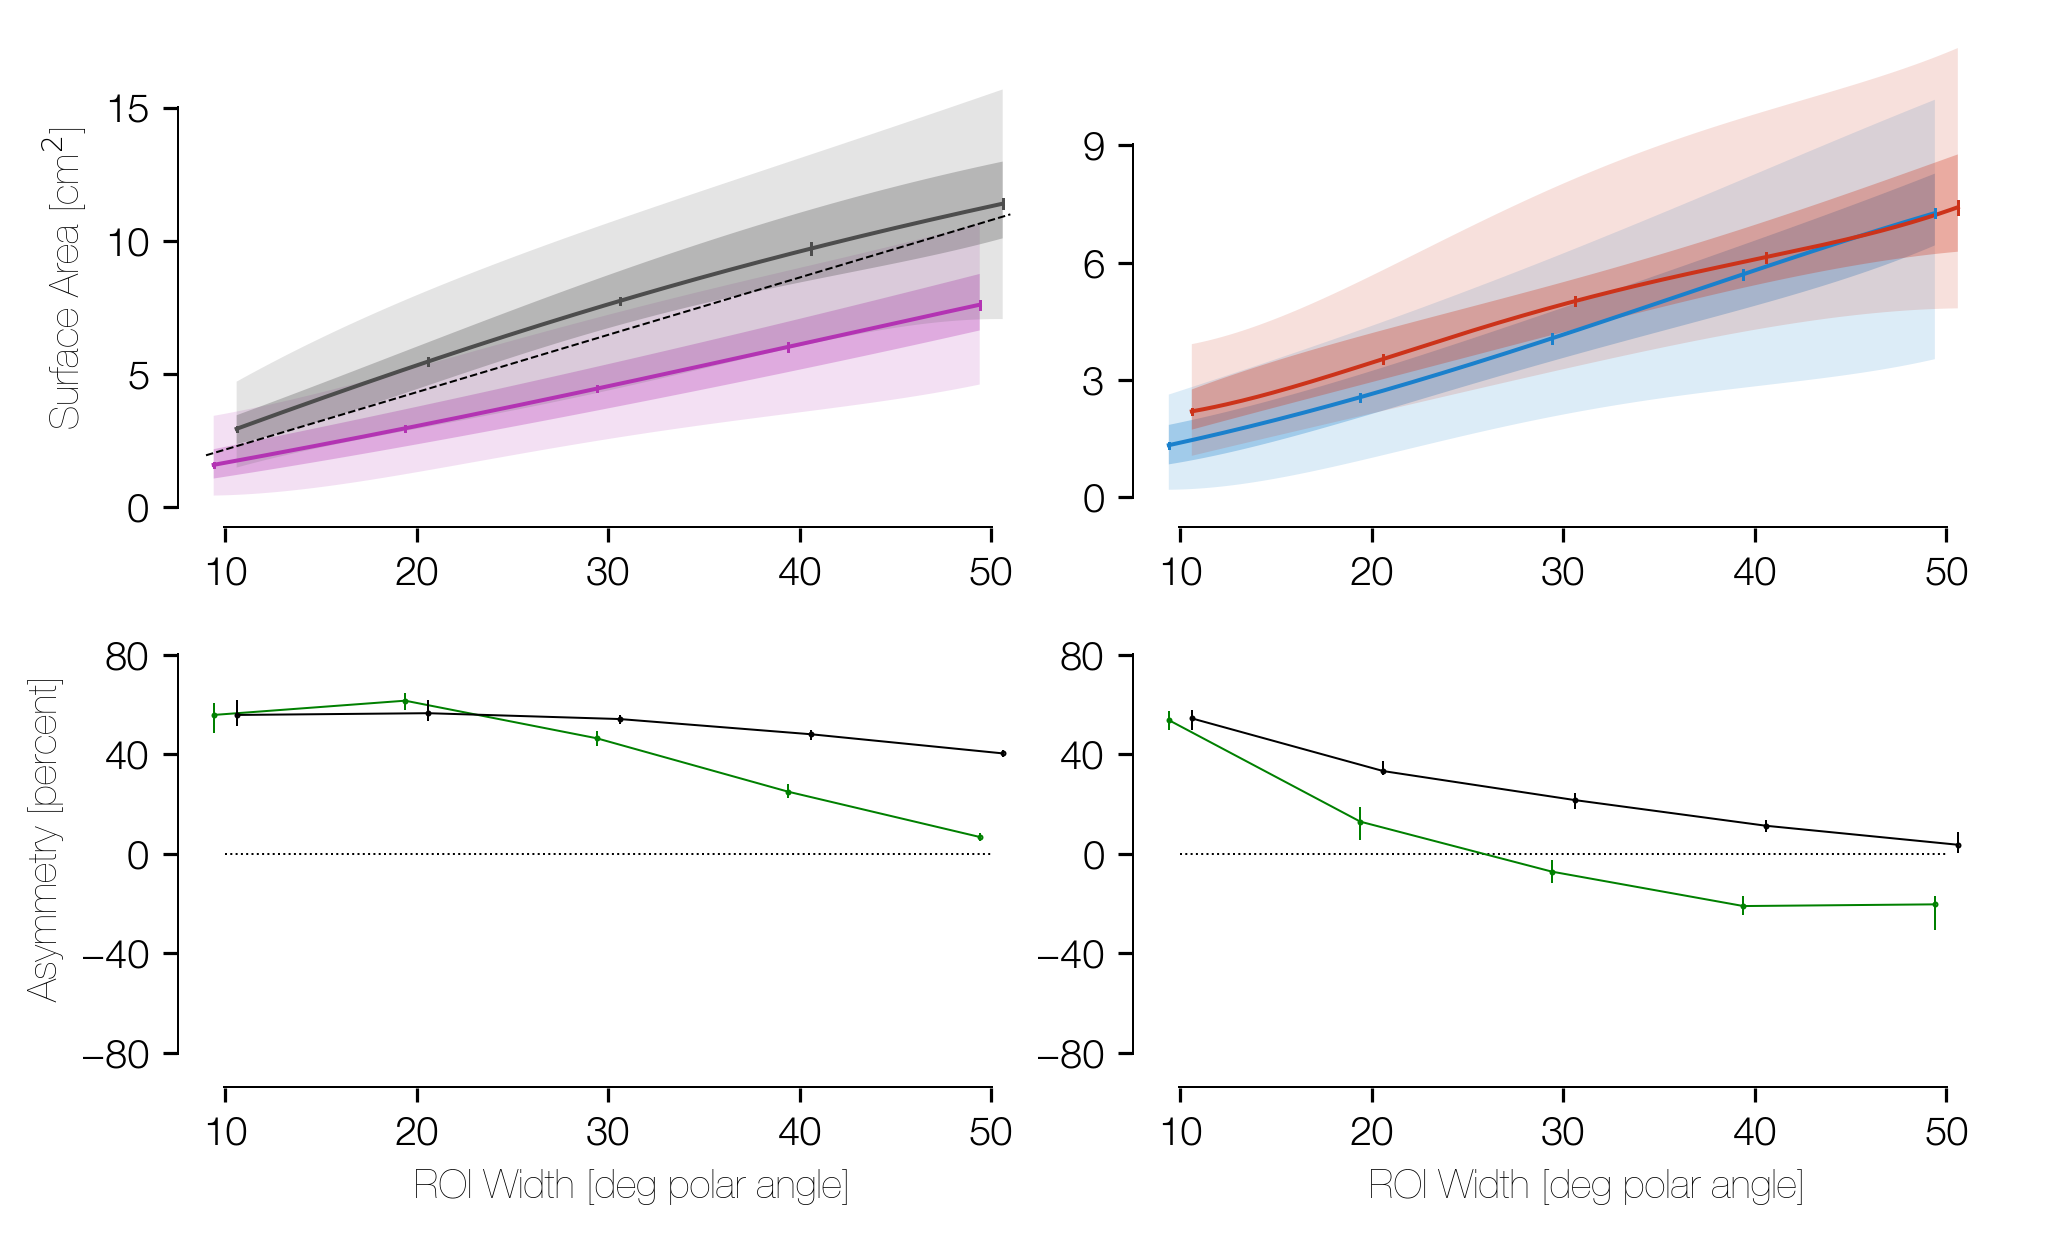

In [24]:
paradigm_order = ['ventral','dorsal','vertical','horizontal']
ylabel = r'Surface Area [cm$^2$]'

# Setup the figure.
(fig,axs) = plt.subplots(2,2, figsize=(7, 4.33), dpi=72*4)
fig.subplots_adjust(0.075,0.125,1,0.975,0.05,0.12)

# Plot the various cumulative plots first.
dx = 0.6
tcum = True
DROI_quant_plot('ventral',    axes=axs[0,1], dx=-dx, cumulative=tcum)
DROI_quant_plot('dorsal',     axes=axs[0,1], dx=dx,  cumulative=tcum)
DROI_quant_plot('vertical',   axes=axs[0,0], dx=-dx, cumulative=tcum)
DROI_quant_plot('horizontal', axes=axs[0,0], dx=dx,  cumulative=tcum)

# Now the rest.
DROI_diff_plot('dorsal',     'ventral',  axes=axs[1,1], dx=-dx)
DROI_diff_plot('horizontal', 'vertical', axes=axs[1,0], dx=-dx)
DROI_diff_plot('dorsal',     'ventral',  axes=axs[1,1], cumulative=True, color=[0,0,0,1], dx=dx)
DROI_diff_plot('horizontal', 'vertical', axes=axs[1,0], cumulative=True, color=[0,0,0,1], dx=dx)

# Fix the limits and axes.
(xmin0, xmax0) = (7.5, 55)
(xmin, xmax) = (10, 50)
for ax in axs.flatten():
    ax.set_xticks(data.roi_angles)
    ax.set_xlim((xmin0, xmax0))
    for sp in six.itervalues(ax.spines): sp.set_visible(False)
#(ymin0, ymax0) = (-1.2, 18)
#(ymin, ymax) = (0, 15)
(ymin0, ymax0) = (-(1.2-1.2/3), 18-18/3)
ymin = 0
for (ax,ymax) in zip(axs[0], [15,9]):
    ymax0 = (ymax + 3)
    ax.set_xticks(data.roi_angles)
    ax.plot([xmin0,xmin0], [ymin,ymax], 'k-', lw=1)
    ax.plot([xmin,xmax], [ymin0,ymin0], 'k-', lw=1)
    ax.set_yticks([0,3,6,9] if ymax == 9 else [0,5,10,15])
    ax.set_ylim((ymin0, ymax0))
axs[0,0].set_ylabel(ylabel)
dy = [(ymax0 - ymax) / (ymax - ymin) * 0.5,
      (ymin0 - ymin) / (ymax - ymin)]
(ymin, ymax) = (-80, 80)
(ymin0, ymax0) = (ymin + dy[1]*(ymax-ymin), ymax + dy[0]*(ymax-ymin))
for ax in axs[1]:
    ax.set_xticks(data.roi_angles)
    ax.set_ylim((ymin0, ymax0))
    ax.set_xlabel('ROI Width [deg polar angle]')
    ax.plot([xmin0,xmin0], [ymin,ymax], 'k-', lw=1)
    ax.plot([xmin,xmax], [ymin0,ymin0], 'k-', lw=1)
    ax.set_yticks([-80, -40, 0, 40, 80])
    ps = ax.plot([xmin, xmax], [0,0], 'k:', lw=0.5)
    for p in ps: p.set_zorder(-2)
axs[1,0].set_ylabel("Asymmetry [percent]")

# Add Horton and Hoyt numbers.
hh_m = 0.2157
# (HH's equation, for 1-6° of eccen, predicts that the surface
# area devoted to ± Q polar angle degrees =
# ~(0.2157 cm^2/deg) (Q deg)
axs[0,0].plot([9, 51], [9*hh_m, 51*hh_m], 'k--', lw=0.5)

if figures_path is not None:
    flnm = os.path.join(figures_path, 'surface_areas.pdf')
    plt.savefig(flnm, dpi=72*8)

### ROIs on the Cortical Surface

These cells demonstrate how to (1) plot the ROIs on the flattened cortical surface and (2) export the ROI data to Mathematica (which is what we used to produce high quality 3D images).

---

**Plotting summary DROI figures for a hemisphere.**

This first cell defines the function `DROI_summary_figure`, which uses the `DROI_cortex_plot` function defined above (`Initialization >> Utility Functions`) to produce summary plots of a given subject's hemisphere. These plots provide a good intuition about the quality of the automated boundary-finding and ROI generation methods.

In [18]:
def DROI_summary_figure(sid, h):
    '''
    DROI_summary_figure(sid, h) yields a pyplot figure object on which has been plotted four panels,
      two for the subject and hemisphere's polar angle and eccentricity and two showing the DROIs
      for the subject.
    '''
    (fig,axs) = plt.subplots(2,2, figsize=(7,7), dpi=288)
    fig.subplots_adjust(0,0,1,1,0,0)
    for ax in axs.flatten(): ax.axis('off')
    DROI_cortex_plot(sid, h, 'prf_polar_angle', surface='flatmap', figure=axs[0,0])
    DROI_cortex_plot(sid, h, 'prf_eccentricity', surface='flatmap', figure=axs[0,1])
    DROI_cortex_plot(sid, h, ['vertical','horizontal'], surface='flatmap', figure=axs[1,0])
    DROI_cortex_plot(sid, h, ['dorsal','ventral'], surface='flatmap', figure=axs[1,1])
    return fig

This cell, when run, will export images of the subjects to the `figures_path` directory. If that directory is `None` then this will do nothing.

In [20]:
if figures_path is not None:
    rois_path = os.path.join(figures_path, 'summaries')
    if not os.path.isdir(rois_path):
        os.makedirs(rois_path, mode=0o664)
    for sid in data.subject_list:
        print(sid)
        for h in ('lh','rh'):
            flnm = os.path.join(rois_path, '%d_%s.png' % (sid,h))
            if os.path.isfile(flnm): continue
            fig = DROI_summary_figure(sid, h)
            plt.savefig(flnm, bbox_inches='tight', dpi=288)
            plt.close(fig)

---

**Export DROI data to Mathematica for plotting.**

For the 3D plots in the paper, we used Mathematica's 3D rendering engine to produce high quality 3D images. As of when this paper/notebook were written, Mathematica produces smoother surfaces and fewer artifacts and allows for more control over lighting.To print the DROI data in a string format that can simply be copied-and-pasted over to Mathematica, you can use this cell.

Note that this produces a fairly large block of text, but for any single hemisphere it should be small enough to paste across programs without issue.

In [ ]:
sid = 177746
h = 'lh'

# These are the rois we will print out.
rois = data.DROI_details[sid][h]

# Generate the text as a list of strings, which we will join.
ss = ["<|"]
for (k,v) in six.iteritems(rois):
    ss.append('"%s" -> <|' % k)
    for (ang,q) in six.iteritems(v):
        q = q['indices']
        ss.append('%d -> {' % ang)
        for (ii,u) in enumerate(q):
            if ii > 0: ss.append(", ")
            ss.append(str(u))
        ss.append('}')
        if ang < 50: ss.append(',')
    ss.append('|>')
    ss.append(',\n')
ss[-1] = "|>"

print(''.join(ss))

### HVA and VMA by Gender and Age

We would like to see if there are differences in the extent of asymmetry in terms of the gender or in terms of age-group data provided by the HCP. Here we plot these data. In this first cell, we build up a dataframe that will make plotting the data using seaborn fairly easy.

In [23]:
# We can start by grabbing the subject ages and genders in the same order as
# is used in data.assymetry, which tracks the HVA and VMA of each subject.
# This order is the same as that given in data.subject_list.
agegroups = [data.agegroup[sid] for sid in data.subject_list]
genders   = [data.gender[sid]   for sid in data.subject_list]

# Now we just make a dataframe; all the columns are already ordered by subject
# ID so we can just put them together. We do, however, need to expand each
# column by the wedge-size because we are flattening that dimension out into
# a single column.
angle_col = 'ROI Width [deg polar angle]'
age_col = 'Age-Group [years]'
gender_col = 'Gender'
data_cols = ['Local HVA', 'Cumulative HVA', 'Local VMA', 'Cumulative VMA']
data_cols = [d + ' [%]' for d in data_cols]
data_keys = ['HVA', 'HVA_cumulative', 'VMA', 'VMA_cumulative']
nsubs = len(data.subject_list)

df = {}
df[angle_col]  = np.reshape([np.full(nsubs, k) for k in data.roi_angles], -1)
df['sid']      = np.reshape([data.subject_list for k in data.roi_angles], -1)
df[gender_col] = np.reshape([genders           for k in data.roi_angles], -1)
df[age_col]    = np.reshape([agegroups         for k in data.roi_angles], -1)
for (col,k) in zip(data_cols, data_keys):
    df[col] = data.asymmetry[k].flatten()
df = ny.to_dataframe(df)
df = df[['sid',age_col,gender_col,angle_col] + data_cols]
df.set_index('sid')

# We call this the asymmetry table.
asymmetry_table = df

pass

To plot these data, we can use [seaborn](https://github.com/mwaskom/seaborn), which makes these kinds of plots fairly simple and straightforward.

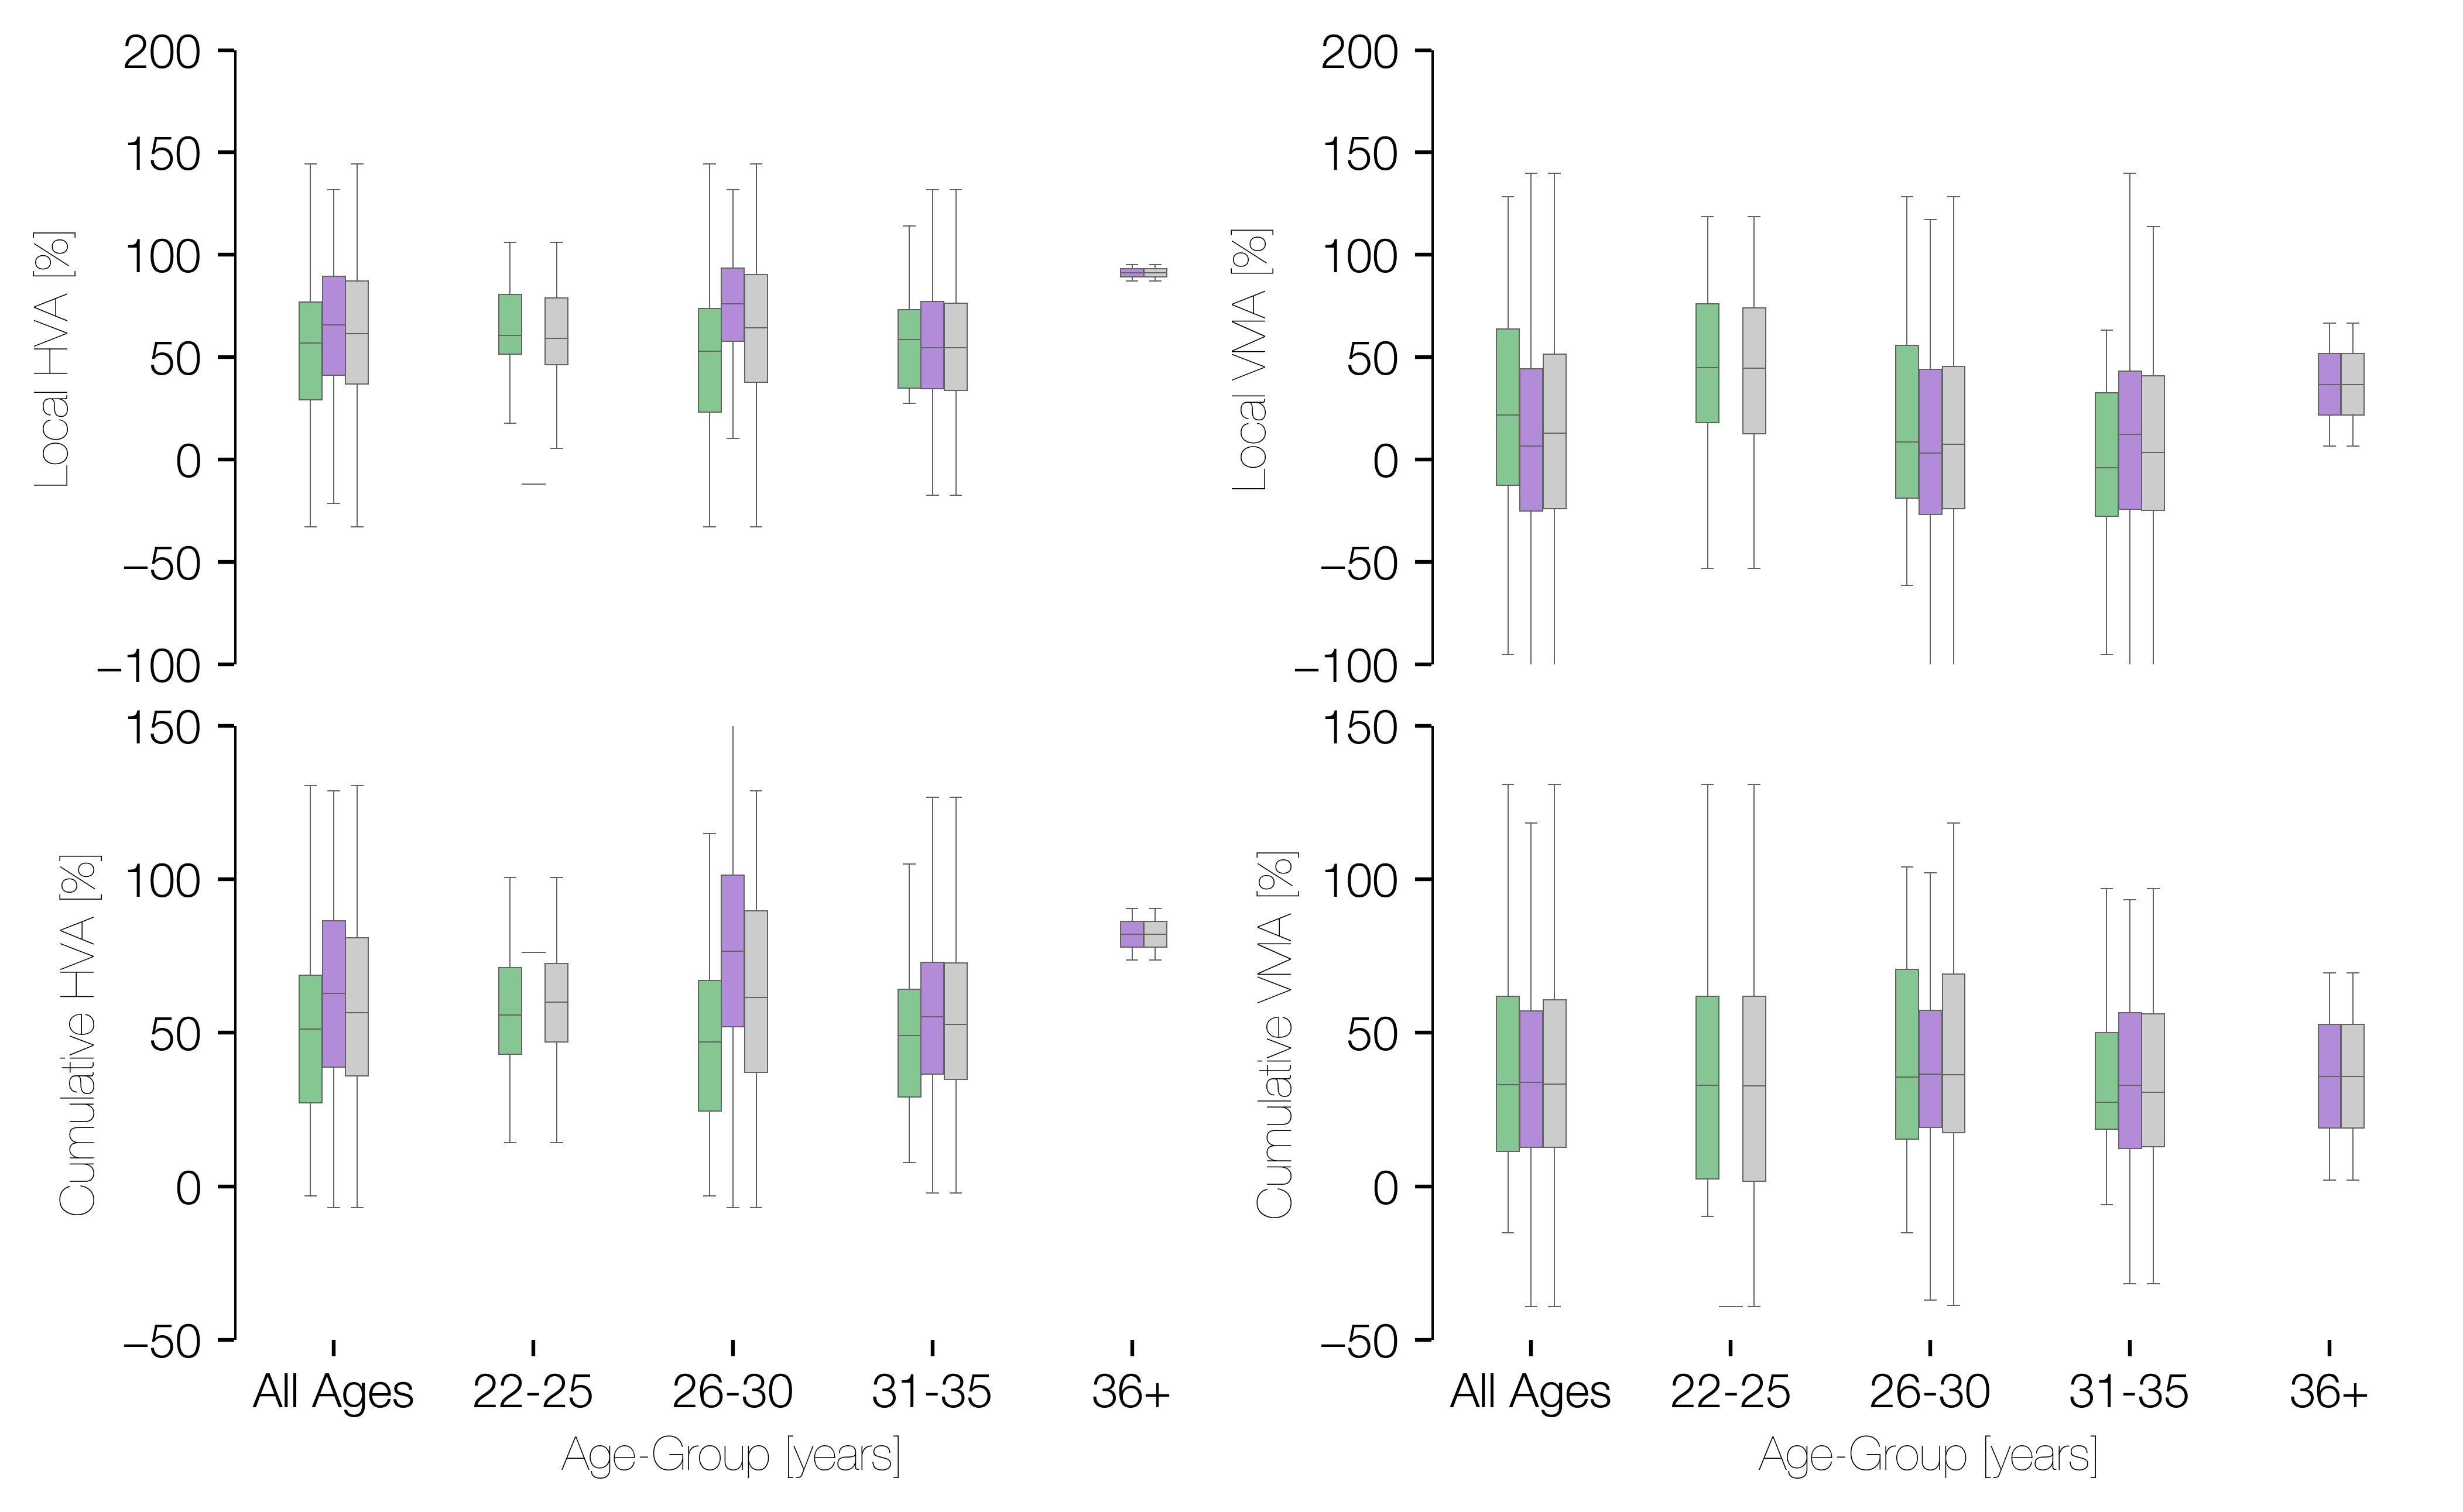

In [24]:
# Setup the figure
(fig,axs) = plt.subplots(2,2, figsize=(7,4.5), dpi=72*8)

# We want to plot these for only the ± 10° wedge.
df = asymmetry_table
df = df.loc[df[angle_col] == 20]

# We also want to be able to plot a both-genders and all-ages category. We can
# most easily facilitate this by adding data to the dataframe.
tmp = pandas.options.mode.chained_assignment
pandas.options.mode.chained_assignment = None
df0 = df.copy()
df[gender_col] = np.full(len(df), 'X')
df = pandas.concat([df0, df])
df0 = df.copy()
df[age_col] = np.zeros(len(df))
df = pandas.concat([df0, df])
pandas.options.mode.chained_assignment = tmp

# We need to makeup a new color for the genders; make it gray.
clrs = {k:colors[k] for k in ['M','F']}
clrs['X'] = (0.8,0.8,0.8)

for (k,ax) in zip(data_cols, axs.T.flatten()):
    sns.boxplot(data=df, x=age_col, y=k, hue=gender_col,
                   palette=clrs, saturation=0.5, dodge=True,
                   ax=ax, linewidth=0.25, width=0.35, fliersize=0)

# Do some post-processing on the figure.
xlim = [-0.5,4.5]
ylims = [[-100,200], [-50,150]]
#yaxlims = [[-100,200], []]
for (axrow,ylim) in zip(axs, ylims):
    for ax in axrow:
        for sp in six.itervalues(ax.spines):
            sp.set_visible(False)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.plot([xlim[0], xlim[0]], ylim, 'k-', lw=1)
        ax.get_legend().remove()
for ax in axs[0]:
    ax.set_xlabel(None)
    ax.set_xticks([])
xlbls = ['All Ages'] + list(np.unique(data.behavioral_table['Age'].values))
for ax in axs[1]:
    ax.set_xticklabels(xlbls)
fig.subplots_adjust(0.07,0.05,1,0.9,0.2,0.1)

if figures_path is not None:
    flnm = os.path.join(figures_path, 'asymmetry_by_demographics.pdf')
    plt.savefig(flnm, dpi=72*8, bbox_inches='tight')

### V1 Sizes in Terms of Gender

Something that we want to be able to examine is the breakdown of V1 sizes in terms of properties like gender and age. This section performs these calculations and plots.

---

These initial functions simply perform the basic calculations about a subject--e.g., what is the surface area of their V1?

In [25]:
def subject_V1_surface_area(sid, h, area_property='midgray_surface_area'):
    hem = data.subjects[sid].hemis[h]
    ii = hem.indices
    for mask in [('inf_visual_area', 1), ('inf_eccentricity', 1, 6)]:
        ii = np.intersect1d(ii, hem.mask(mask))
    return np.nansum(hem.property(area_property, mask=ii))
def subject_V1_thickness(sid, h):
    hem = data.subjects[sid].hemis[h]
    ii = hem.indices
    for mask in [('inf_visual_area', 1), ('inf_eccentricity', 1, 6)]:
        ii = np.intersect1d(ii, hem.mask(mask))
    return np.nanmean(hem.property('thickness', mask=ii))
def subject_V1_volume(sid, h, area_property='midgray_surface_area'):
    hem = data.subjects[sid].hemis[h]
    ii = hem.indices
    for mask in [('inf_visual_area', 1), ('inf_eccentricity', 1, 6)]:
        ii = np.intersect1d(ii, hem.mask(mask))
    area = hem.property(area_property, mask=ii)
    thic = hem.property('thickness', mask=ii)
    return np.nansum(area * thic)
def subject_cortex_surface_area(sid, h, area_property='midgray_surface_area'):
    hem = data.subjects[sid].hemis[h]
    ii = hem.mask('cortex_label')
    return np.nansum(hem.property(area_property, mask=ii))
def subject_cortex_volume(sid, h, area_property='midgray_surface_area'):
    hem = data.subjects[sid].hemis[h]
    ii = hem.mask('cortex_label')
    area = hem.property(area_property, mask=ii)
    thic = hem.property('thickness', mask=ii)
    return np.nansum(area * thic)

---

To make this plot, we want to use seaborn; we will build up a dataframe that makes the plotting easy.

In [26]:
dat = ny.auto_dict(None, [])
for sid in data.subject_list:
    for h in ['lh','rh']:
        dat['sid'].append(sid)
        dat['Gender'].append(data.gender[sid])
        dat['Age'].append(data.agegroup[sid])
        v1sa = subject_V1_surface_area(sid,h) / 100.0
        v1vo = subject_V1_volume(sid,h) / 1000.0
        cxsa = subject_cortex_surface_area(sid,h) / 100.0
        cxvo = subject_cortex_volume(sid,h) / 1000.0
        dat[r'V1 Surface Area [cm$^2$]'].append(v1sa)
        dat[r'V1 Gray Volume [cm$^3$]'].append(v1vo)
        dat[r'Mean V1 Gray Thickness [mm]'].append(subject_V1_thickness(sid,h))
        dat[r'Cortex Surface Area [cm$^2$]'].append(cxsa)
        dat[r'Cortex Gray Volume [cm$^3$]'].append(cxvo)
        dat[r'Normalized V1 Surface Area [%]'].append(v1sa / cxsa * 100)
        dat[r'Normalized V1 Gray Volume [%]'].append(v1vo / cxvo * 100)
dat = ny.to_dataframe(dat)

Here, we make the plot.

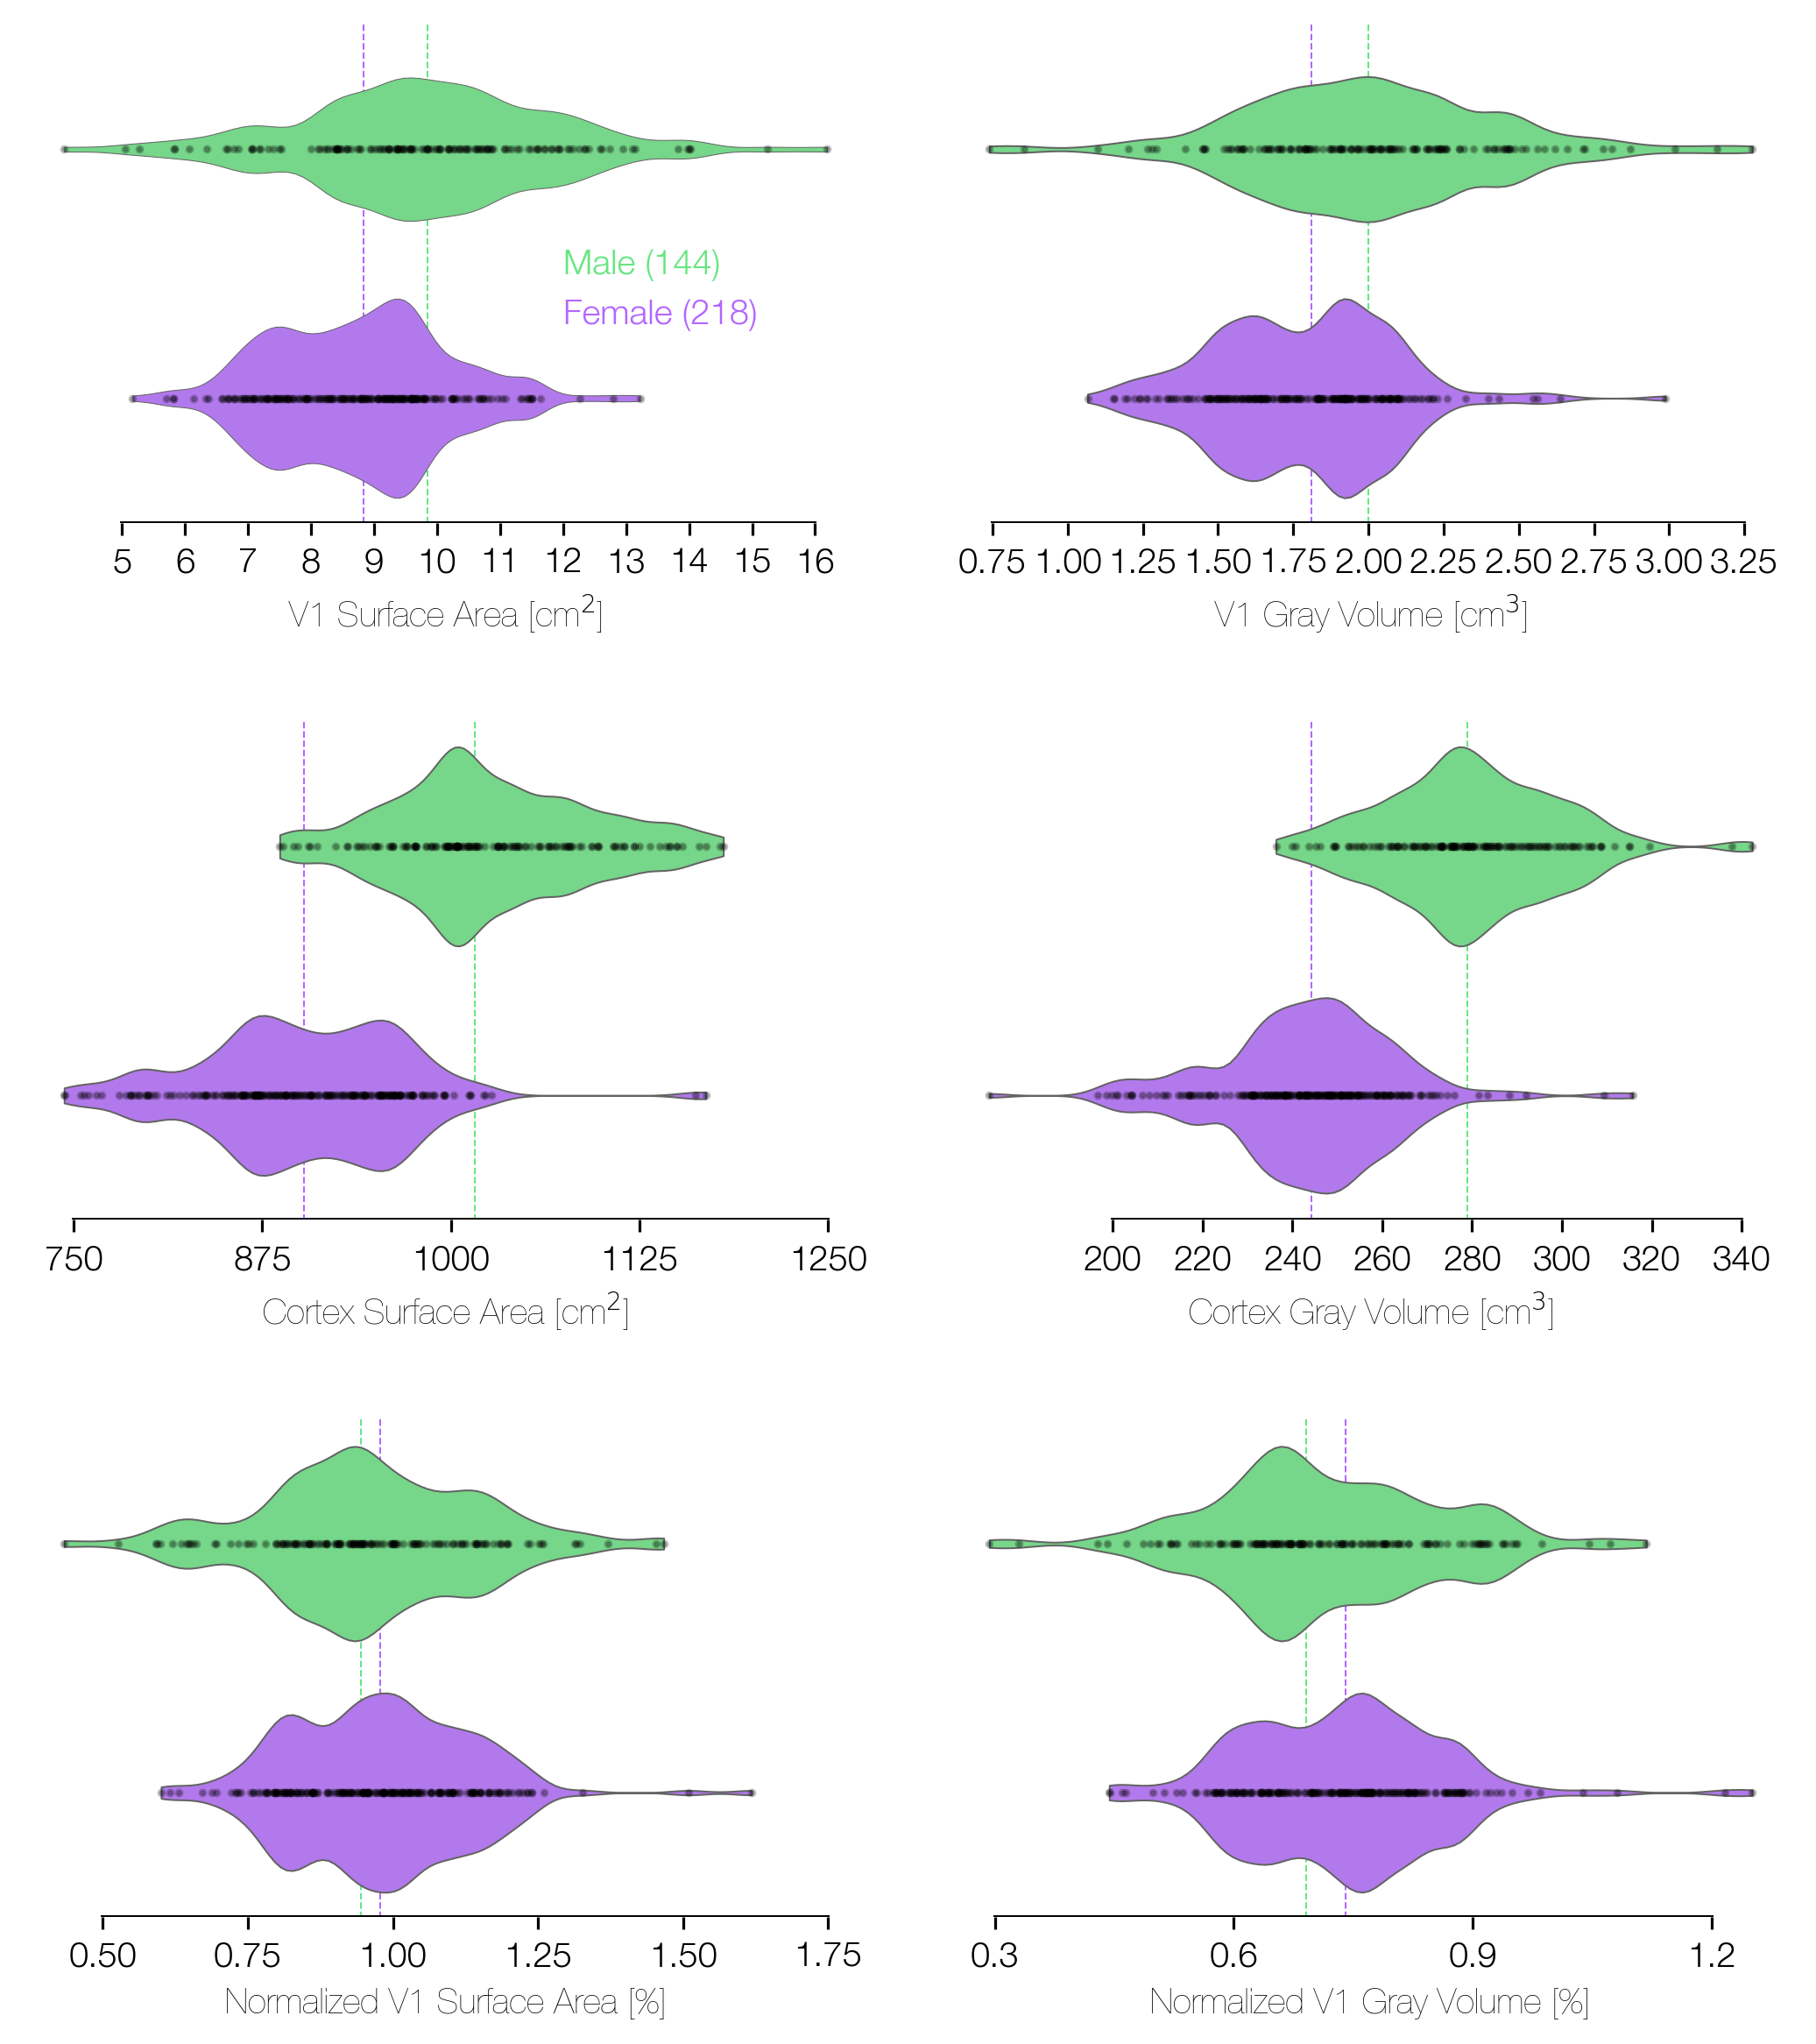

In [27]:
(f,axs) = plt.subplots(3,2, dpi=72*4, figsize=(7,7.5))

# We are plotting Gender here.
prop = 'Gender'

# Surface Area!
ax = axs[0,0]
sk = r'V1 Surface Area [cm$^2$]'
sns.violinplot(x=sk, y=prop, data=dat, palette=[colors['M'], colors['F']],
               split=True, ax=ax, cut=0, bw=0.2, inner=None, linewidth=0.25)
for (y,g) in zip([0,1], ['M','F']):
    xs = [r[sk] for (ii,r) in dat.iterrows() if r[prop] == g]
    ax.scatter(xs, [y]*len(xs), c=[(0,0,0,0.25)], s=2)
ax.set_ylabel(None)
ax.set_yticks([])
ax.set_xticks(range(5,17))
ax.plot([5,16],[1.5,1.5], 'k-', lw=1)
ax.set_ylim(1.5,-0.5)
for s in ['top','right','left','bottom']: ax.spines[s].set_visible(False)
# Draw the two median lines
(m, f) = [np.median(ny.util.dataframe_select(dat, Gender=q)[sk].values)
          for q in ['M','F']]
for p in ax.plot([m,m], [-0.5,1.5], '--', lw=0.5, c=colors['M']): p.set_zorder(-1)
for p in ax.plot([f,f], [-0.5,1.5], '--', lw=0.5, c=colors['F']): p.set_zorder(-1)
(nm,nf) = [len([1 for (ii,r) in dat.iterrows() if r[prop] == g])
           for g in ['M','F']]
ax.text(12, 0.5, 'Male (%d)' % nm,   color=colors['M'])
ax.text(12, 0.7, 'Female (%d)' % nf, color=colors['F'])

ax = axs[1,0]
sk = r'Cortex Surface Area [cm$^2$]'
sns.violinplot(x=sk, y=prop, data=dat, palette=[colors['M'], colors['F']],
               split=True, ax=ax, cut=0, bw=0.2, inner=None, linewidth=0.5)
for (y,g) in zip([0,1], ['M','F']):
    xs = [r[sk] for (ii,r) in dat.iterrows() if r[prop] == g]
    ax.scatter(xs, [y]*len(xs), c=[(0,0,0,0.25)], s=2)
ax.set_ylabel(None)
ax.set_yticks([])
ax.set_xticks(range(750,1251,125))
ax.plot([750,1250],[1.5,1.5], 'k-', lw=1)
ax.set_ylim(1.5,-0.5)
for s in ['top','right','left','bottom']: ax.spines[s].set_visible(False)
# Draw the two median lines
(m, f) = [np.median(ny.util.dataframe_select(dat, Gender=q)[sk].values)
          for q in ['M','F']]
for p in ax.plot([m,m], [-0.5,1.5], '--', lw=0.5, c=colors['M']): p.set_zorder(-1)
for p in ax.plot([f,f], [-0.5,1.5], '--', lw=0.5, c=colors['F']): p.set_zorder(-1)
(nm,nf) = [len([1 for (ii,r) in dat.iterrows() if r[prop] == g])
           for g in ['M','F']]

ax = axs[2,0]
sk = r'Normalized V1 Surface Area [%]'
sns.violinplot(x=sk, y=prop, data=dat, palette=[colors['M'], colors['F']],
               split=True, ax=ax, cut=0, bw=0.2, inner=None, linewidth=0.5)
for (y,g) in zip([0,1], ['M','F']):
    xs = [r[sk] for (ii,r) in dat.iterrows() if r[prop] == g]
    ax.scatter(xs, [y]*len(xs), c=[(0,0,0,0.25)], s=2)
ax.set_ylabel(None)
ax.set_yticks([])
ax.set_xticks(np.arange(0.5,1.76,0.25))
ax.plot([0.5,1.75],[1.5,1.5], 'k-', lw=1)
ax.set_ylim(1.5,-0.5)
for s in ['top','right','left','bottom']: ax.spines[s].set_visible(False)
# Draw the two median lines
(m, f) = [np.median(ny.util.dataframe_select(dat, Gender=q)[sk].values)
          for q in ['M','F']]
for p in ax.plot([m,m], [-0.5,1.5], '--', lw=0.5, c=colors['M']): p.set_zorder(-1)
for p in ax.plot([f,f], [-0.5,1.5], '--', lw=0.5, c=colors['F']): p.set_zorder(-1)
(nm,nf) = [len([1 for (ii,r) in dat.iterrows() if r[prop] == g])
           for g in ['M','F']]

# Volume!
ax = axs[0,1]
sk = r'V1 Gray Volume [cm$^3$]'
sns.violinplot(x=sk, y=prop, data=dat, palette=[colors['M'], colors['F']],
               split=True, ax=ax, cut=0, bw=0.2, inner=None, linewidth=0.5)
for (y,g) in zip([0,1], ['M','F']):
    xs = [r[sk] for (ii,r) in dat.iterrows() if r[prop] == g]
    ax.scatter(xs, [y]*len(xs), c=[(0,0,0,0.25)], s=2)
ax.set_ylabel(None)
ax.set_yticks([])
ax.set_xticks(np.arange(0.75, 3.26, 0.25))
ax.plot([0.75, 3.25],[1.5,1.5], 'k-', lw=1)
ax.set_ylim(1.5,-0.5)
for s in ['top','right','left','bottom']: ax.spines[s].set_visible(False)
# Draw the two median lines
(m, f) = [np.median(ny.util.dataframe_select(dat, Gender=q)[sk].values)
          for q in ['M','F']]
for p in ax.plot([m,m], [-0.5,1.5], '--', lw=0.5, c=colors['M']): p.set_zorder(-1)
for p in ax.plot([f,f], [-0.5,1.5], '--', lw=0.5, c=colors['F']): p.set_zorder(-1)

ax = axs[1,1]
sk = r'Cortex Gray Volume [cm$^3$]'
sns.violinplot(x=sk, y=prop, data=dat, palette=[colors['M'], colors['F']],
               split=True, ax=ax, cut=0, bw=0.2, inner=None, linewidth=0.5)
for (y,g) in zip([0,1], ['M','F']):
    xs = [r[sk] for (ii,r) in dat.iterrows() if r[prop] == g]
    ax.scatter(xs, [y]*len(xs), c=[(0,0,0,0.25)], s=2)
ax.set_ylabel(None)
ax.set_yticks([])
ax.set_xticks(np.arange(200, 341, 20))
ax.plot([200, 340],[1.5,1.5], 'k-', lw=1)
ax.set_ylim(1.5,-0.5)
for s in ['top','right','left','bottom']: ax.spines[s].set_visible(False)
# Draw the two median lines
(m, f) = [np.median(ny.util.dataframe_select(dat, Gender=q)[sk].values)
          for q in ['M','F']]
for p in ax.plot([m,m], [-0.5,1.5], '--', lw=0.5, c=colors['M']): p.set_zorder(-1)
for p in ax.plot([f,f], [-0.5,1.5], '--', lw=0.5, c=colors['F']): p.set_zorder(-1)
    
ax = axs[2,1]
sk = r'Normalized V1 Gray Volume [%]'
sns.violinplot(x=sk, y=prop, data=dat, palette=[colors['M'], colors['F']],
               split=True, ax=ax, cut=0, bw=0.2, inner=None, linewidth=0.5)
for (y,g) in zip([0,1], ['M','F']):
    xs = [r[sk] for (ii,r) in dat.iterrows() if r[prop] == g]
    ax.scatter(xs, [y]*len(xs), c=[(0,0,0,0.25)], s=2)
ax.set_ylabel(None)
ax.set_yticks([])
ax.set_xticks(np.arange(0.3,1.25,0.3))
ax.plot([0.3,1.2],[1.5,1.5], 'k-', lw=1)
ax.set_ylim(1.5,-0.5)
for s in ['top','right','left','bottom']: ax.spines[s].set_visible(False)
# Draw the two median lines
(m, f) = [np.median(ny.util.dataframe_select(dat, Gender=q)[sk].values)
          for q in ['M','F']]
for p in ax.plot([m,m], [-0.5,1.5], '--', lw=0.5, c=colors['M']): p.set_zorder(-1)
for p in ax.plot([f,f], [-0.5,1.5], '--', lw=0.5, c=colors['F']): p.set_zorder(-1)
    
plt.subplots_adjust(0,0,1,1,0.1,0.4)
if figures_path is not None:
    flnm = os.path.join(figures_path, 'V1-size_by_gender.pdf')
    plt.savefig(flnm, bbox_inches='tight', dpi=8*72)

### Comparison with Behavioral Data

#### Plot of the Barbot *et al.* (2020) behavioral data

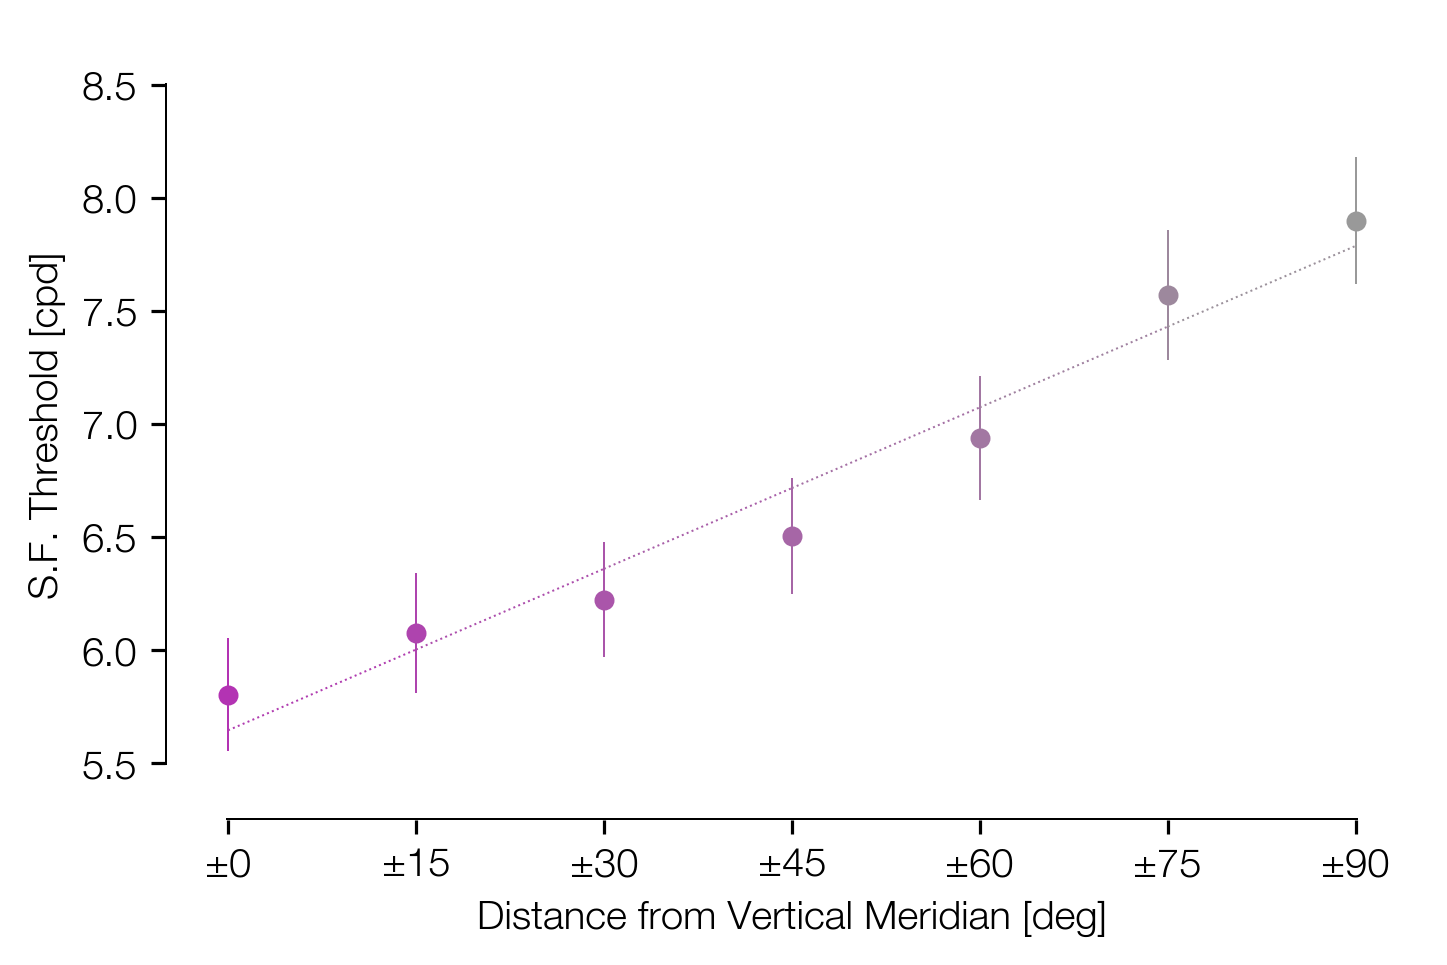

In [31]:
x0 = barbot2020_data['angles']
y0 = barbot2020_data['matrix']

xs = np.flip(x0[6:])
(ymu,ysd) = [[f(np.concatenate([y0[k], y0[12-k]])) for k in range(7)]
             for f in [np.nanmean, np.nanstd]]

(fig,ax) = plt.subplots(1,1, figsize=(4.35,2.75), dpi=72*4)
fig.subplots_adjust(0,0,1,1,0,0)
for sp in ax.spines.values(): sp.set_visible(False)

ax.set_xticks([0,15,30,45,60,75,90])
ax.set_xticklabels(['±0','±15','±30','±45','±60','±75','±90'])
ax.set_yticks(np.arange(5.5,8.6,0.5))
ax.set_xlim([-5,95])
ax.set_ylim([5.25,8.75])
ax.plot([0,90],[5.25,5.25], 'k-', lw=1)
ax.plot([-5,-5],[5.5,8.5], 'k-', lw=1)
ax.set_xlabel('Distance from Vertical Meridian [deg]', fontdict={'weight':'light'})
ax.set_ylabel('S.F. Threshold [cpd]', fontdict={'weight':'light'})


beh_data = []
clrs = np.transpose([np.linspace(v, h, len(xs)) for (v,h) in zip(colors['vertical'], colors['horizontal'])])
for (x,y,s,c) in zip(xs, ymu, ysd/np.sqrt(len(xs)*2), clrs):
    ax.plot(x, y, 'o', c=c, ms=4)
    ax.plot([x,x], [y-s,y+s], '-', c=c, lw=0.5)
    beh_data.append((x, y-s,y,y+s))

(m,b) = np.polyfit(xs, ymu, 1)
#ax.plot([-5,95], [b-5*m, b+95*m], '--', c=np.mean(clrs, axis=0))
for (x0,x1,y0,y1,c) in zip(xs[:-1],xs[1:], ymu[:-1],ymu[1:], np.mean([clrs[:-1],clrs[1:]], axis=0)):
    ax.plot([x0,x1], [b+x0*m,b+x1*m], ':', c=c, lw=0.5)

#### Behavior-matched ROIs

In [15]:
# This may be set to None if you don't want to save these data.
# Note that the behavior-match file isn't currently part of the OSF page,
# so this must be recalculated.
behavior_match_filename = os.path.join(data.pseudo_path.cache_path,
                                       'behavior_matched_DROI_table.csv')
# These are the angle-widths and eccentricities used to generate the
# behavior-match ROIs.
behavior_match_angles = [7.5, 22.5, 37.5, 45]
behavior_match_eccens = [(4,4.5), (4.5,5)]

if behavior_match_filename is None and os.path.isfile(behavior_match_filename):
    behavior_match_table = ny.load(behavior_match_filename)
else:
    behavior_match_tables = data.generate_DROI_tables(
        nprocs=30,
        method='mean',
        angles=behavior_match_angles,
        eccens=behavior_match_eccens)
    behavior_match_table = pandas.concat(list(behavior_match_tables.values()))
    if behavior_match_filename is not None:
        ny.save(behavior_match_filename, behavior_match_table)

behavior_match_summary = visual_performance_fields.VisualPerformanceFieldsDataset.generate_DROI_summary(
    behavior_match_table,
    angles=behavior_match_angles,
    eccens=behavior_match_eccens)

<ipython-input-16-91520787634c>:69: RuntimeWarning: Mean of empty slice
  [np.nanmean([vnt_data, drs_data], axis=0)],


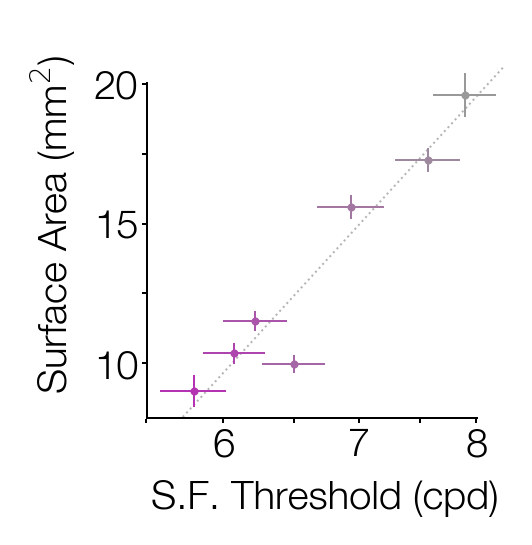

In [16]:
# First, configure this plot. What angles and summary data?
angles = np.asarray(behavior_match_angles)
summary = behavior_match_summary
prop = 'surface_area_mm2'
# Set to True if you want to plot upper and lower together (averaged), otherwise, set to False.
together = True

vnt_cumdata = np.array([summary[subfield][prop] for subfield in ['ventral_v1', 'hventral']])# / 100
drs_cumdata = np.array([summary[subfield][prop] for subfield in ['dorsal_v1',  'hdorsal']])# / 100
# Convert cumdulative wedge sizes into local wedge sizes
vnt_data = np.zeros(vnt_cumdata.shape)
drs_data = np.zeros(drs_cumdata.shape)
for (cumdat,dat) in zip([vnt_cumdata, drs_cumdata], [vnt_data, drs_data]):
    for (cumsub,sub) in zip(cumdat,dat):
        cumsum = 0
        for (cumwedge,wedge) in zip(cumsub,sub):
            wedge[:] = cumwedge - cumsum
            cumsum = cumwedge

# Now combine these into a single stack that goes from VM to HM.
# Note that we divide all of these except the VM wedges by 2; this
# is because we have to average the LH<>RH ROIs while only summing
# the ROIs around the VM (which are not double-represented in the
# hemispheres in the same way).
delta_ang = np.diff(behavior_match_angles)
vnt_data[vnt_data < 0] = np.nan
drs_data[drs_data < 0] = np.nan
(vdat,vhdat) = vnt_data
(ddat,dhdat) = drs_data
vnt_data = np.vstack(
    [[vdat[0]], # The -7.5 to +7.5° ROI around the VM
     vdat[1:-1], 
     [(vdat[-1] + vhdat[-1])], # The 15° about the intercardinals
     np.flipud(vhdat[1:-1]),
     [(dhdat[0] + vhdat[0])]]) # The -7.5 to 7.5° ROI around the HM
drs_data = np.vstack(
    [[ddat[0]], # The -7.5 to +7.5° ROI around the VM
     ddat[1:-1], 
     [(ddat[-1] + dhdat[-1])], # The 15° about the intercardinals
     np.flipud(dhdat[1:-1]),
     [(dhdat[0] + vhdat[0])]]) # The -7.5 to 7.5° ROI around the HM
wgts = np.concatenate([[1], 7.5/delta_ang[:-1],
                       [7.5/(2*delta_ang[-1])],
                       7.5/np.flip(delta_ang[:-1]), [0.5]])
wgts = np.reshape(wgts, (-1,1))
vnt_data *= wgts
drs_data *= wgts

assert np.nansum(ny.util.nanlt(vnt_data, 0)) == 0
assert np.nansum(ny.util.nanlt(drs_data, 0)) == 0

# We have the data setup. Make the figure.
n = drs_data.shape[0]
(fig,ax) = plt.subplots(1,1, figsize=(1.6,1.8), dpi=72*4)
vntclrs = np.transpose(
    [np.linspace(a, b, n) for (a,b) in zip(colors['ventral'], colors['horizontal'])])
drsclrs = np.transpose(
    [np.linspace(a, b, n) for (a,b) in zip(colors['dorsal'], colors['horizontal'])])
hvaclrs = np.transpose(
    [np.linspace(a, b, n) for (a,b) in zip(colors['vertical'], colors['horizontal'])])

# Depending on whether we are plotting ventral/dorsal together, we need to setup the
# next step (the loop below) to iterate over the right data and colors!
behavior_mean = barbot2020_data['mean']
behavior_sem = barbot2020_data['sem']
if together:
    iterator = zip([np.nanmean([behavior_mean[:7], np.flip(behavior_mean[6:])], axis=0)],
                   [np.nanmean([behavior_sem[:7], np.flip(behavior_sem[6:])], axis=0)],
                   [np.nanmean([vnt_data, drs_data], axis=0)],
                   [hvaclrs])
else:
    # We are not plotting them together
    iterator = zip([behavior_mean[:6], np.flip(behavior_mean[6:])],
                   [behavior_sem[:6], np.flip(behavior_sem[6:])],
                   [vnt_data, drs_data],
                   [vntclrs, drsclrs])

#ys = np.vstack([y0[:-1], [np.mean([y0[-1], y1[-1]], axis=0)], np.flipud(y1[:-1])]) / 100
xcorr = []
ycorr = []
xs = np.arange(0,91,15)
for (behmu,behse,angdata,clrs) in iterator:
    mu = np.nanmean(angdata, axis=1)
    sem = np.sqrt(np.nanvar(angdata, axis=1)/np.sum(np.isfinite(angdata), axis=1))

    # Plot the data; first do the points themselves ± SEMs
    for (xmu,xsem,ymu,ysem,clr) in zip(behmu, behse, mu, sem, clrs):
        xcorr.append(xmu)
        ycorr.append(ymu)
        clr = tuple(clr) + (1,)
        xln = (xmu-xsem,xmu+xsem)
        yln = (ymu-ysem,ymu+ysem)
        ax.scatter(xmu, ymu, c=[clr], s=1)
        ax.plot([xmu,xmu], yln, c=clr, lw=0.5)
        ax.plot(xln, [ymu,ymu], c=clr, lw=0.5)
    # Fit and plot the best-fit line
    if together:
        (m,b) = np.polyfit(np.log(behmu), mu, 1)
        (x0,x1) = (np.log(behmu[0]-1), np.log(behmu[-1]+1))
        p = ax.plot([np.exp(x0), np.exp(x1)], [b+x0*m,b+x1*m], ':', c=(0.7,0.7,0.7), lw=0.5)
        for p in p: p.set_zorder(-10)
    
ax.set_xlabel(r'S.F. Threshold (cpd)', fontdict={'weight':'light'})
ax.set_ylabel(r'Surface Area (mm$^2$)', fontdict={'weight':'light'})
for sp in ['top','left','bottom','right']:
    ax.spines[sp].set_visible(False)

(xmn,xmx) = [5.5,8.25]
(ymn,ymx) = [8,20]
#(ymn,ymx) = [1,30]
ax.set_xscale('log', basex=np.e)
ax.set_xlim([xmn,xmx])
ax.set_ylim([ymn,22])
ax.set_xticks([5.5,6,6.5,7,7.5,8])
ax.set_xticklabels(['',6,'',7,'',8])
ax.set_yticks([10,12.5,15,17.5,20])
ax.set_yticklabels([10,'',15,'',20])

w = 1
ax.xaxis.set_tick_params(width=0.5, length=1, pad=1)
ax.yaxis.set_tick_params(width=0.5, length=1, pad=1)
ax.plot([xmn,8], [ymn,ymn], 'k-', lw=w)
ax.plot([xmn,xmn], [ymn,ymx], 'k-', lw=w)

plt.savefig(os.path.join(figures_path, 'behavior-sarea-compare.pdf'),
            bbox_inches='tight')

None

### Asymmetry Correlations between Twin-pairs

Start by building up pair-data for both MZ and DZ twins.

In [95]:
pair_data = ny.auto_dict(None, [])
sid_to_index = {sid: k for (k,sid) in enumerate(data.subject_list)}
for rel in ['MZ','DZ']:
    for (t1,t2) in six.iteritems(data.retinotopy_siblings[rel]):
        if t2 < t1: continue
        (k1,k2) = [sid_to_index[t] for t in (t1,t2)]
        pair_data['sid_1'].append(t1)
        pair_data['sid_2'].append(t2)
        pair_data['relationship'].append(rel)
        for col in ['HVA','VMA']:
            for (ii,w) in enumerate([10,20,30,40,50]):
                pair_data['%s%d_1' % (col,w)].append(data.asymmetry[col+'_cumulative'][ii][k1])
                pair_data['%s%d_2' % (col,w)].append(data.asymmetry[col+'_cumulative'][ii][k2])
pair_data = ny.to_dataframe(pair_data)

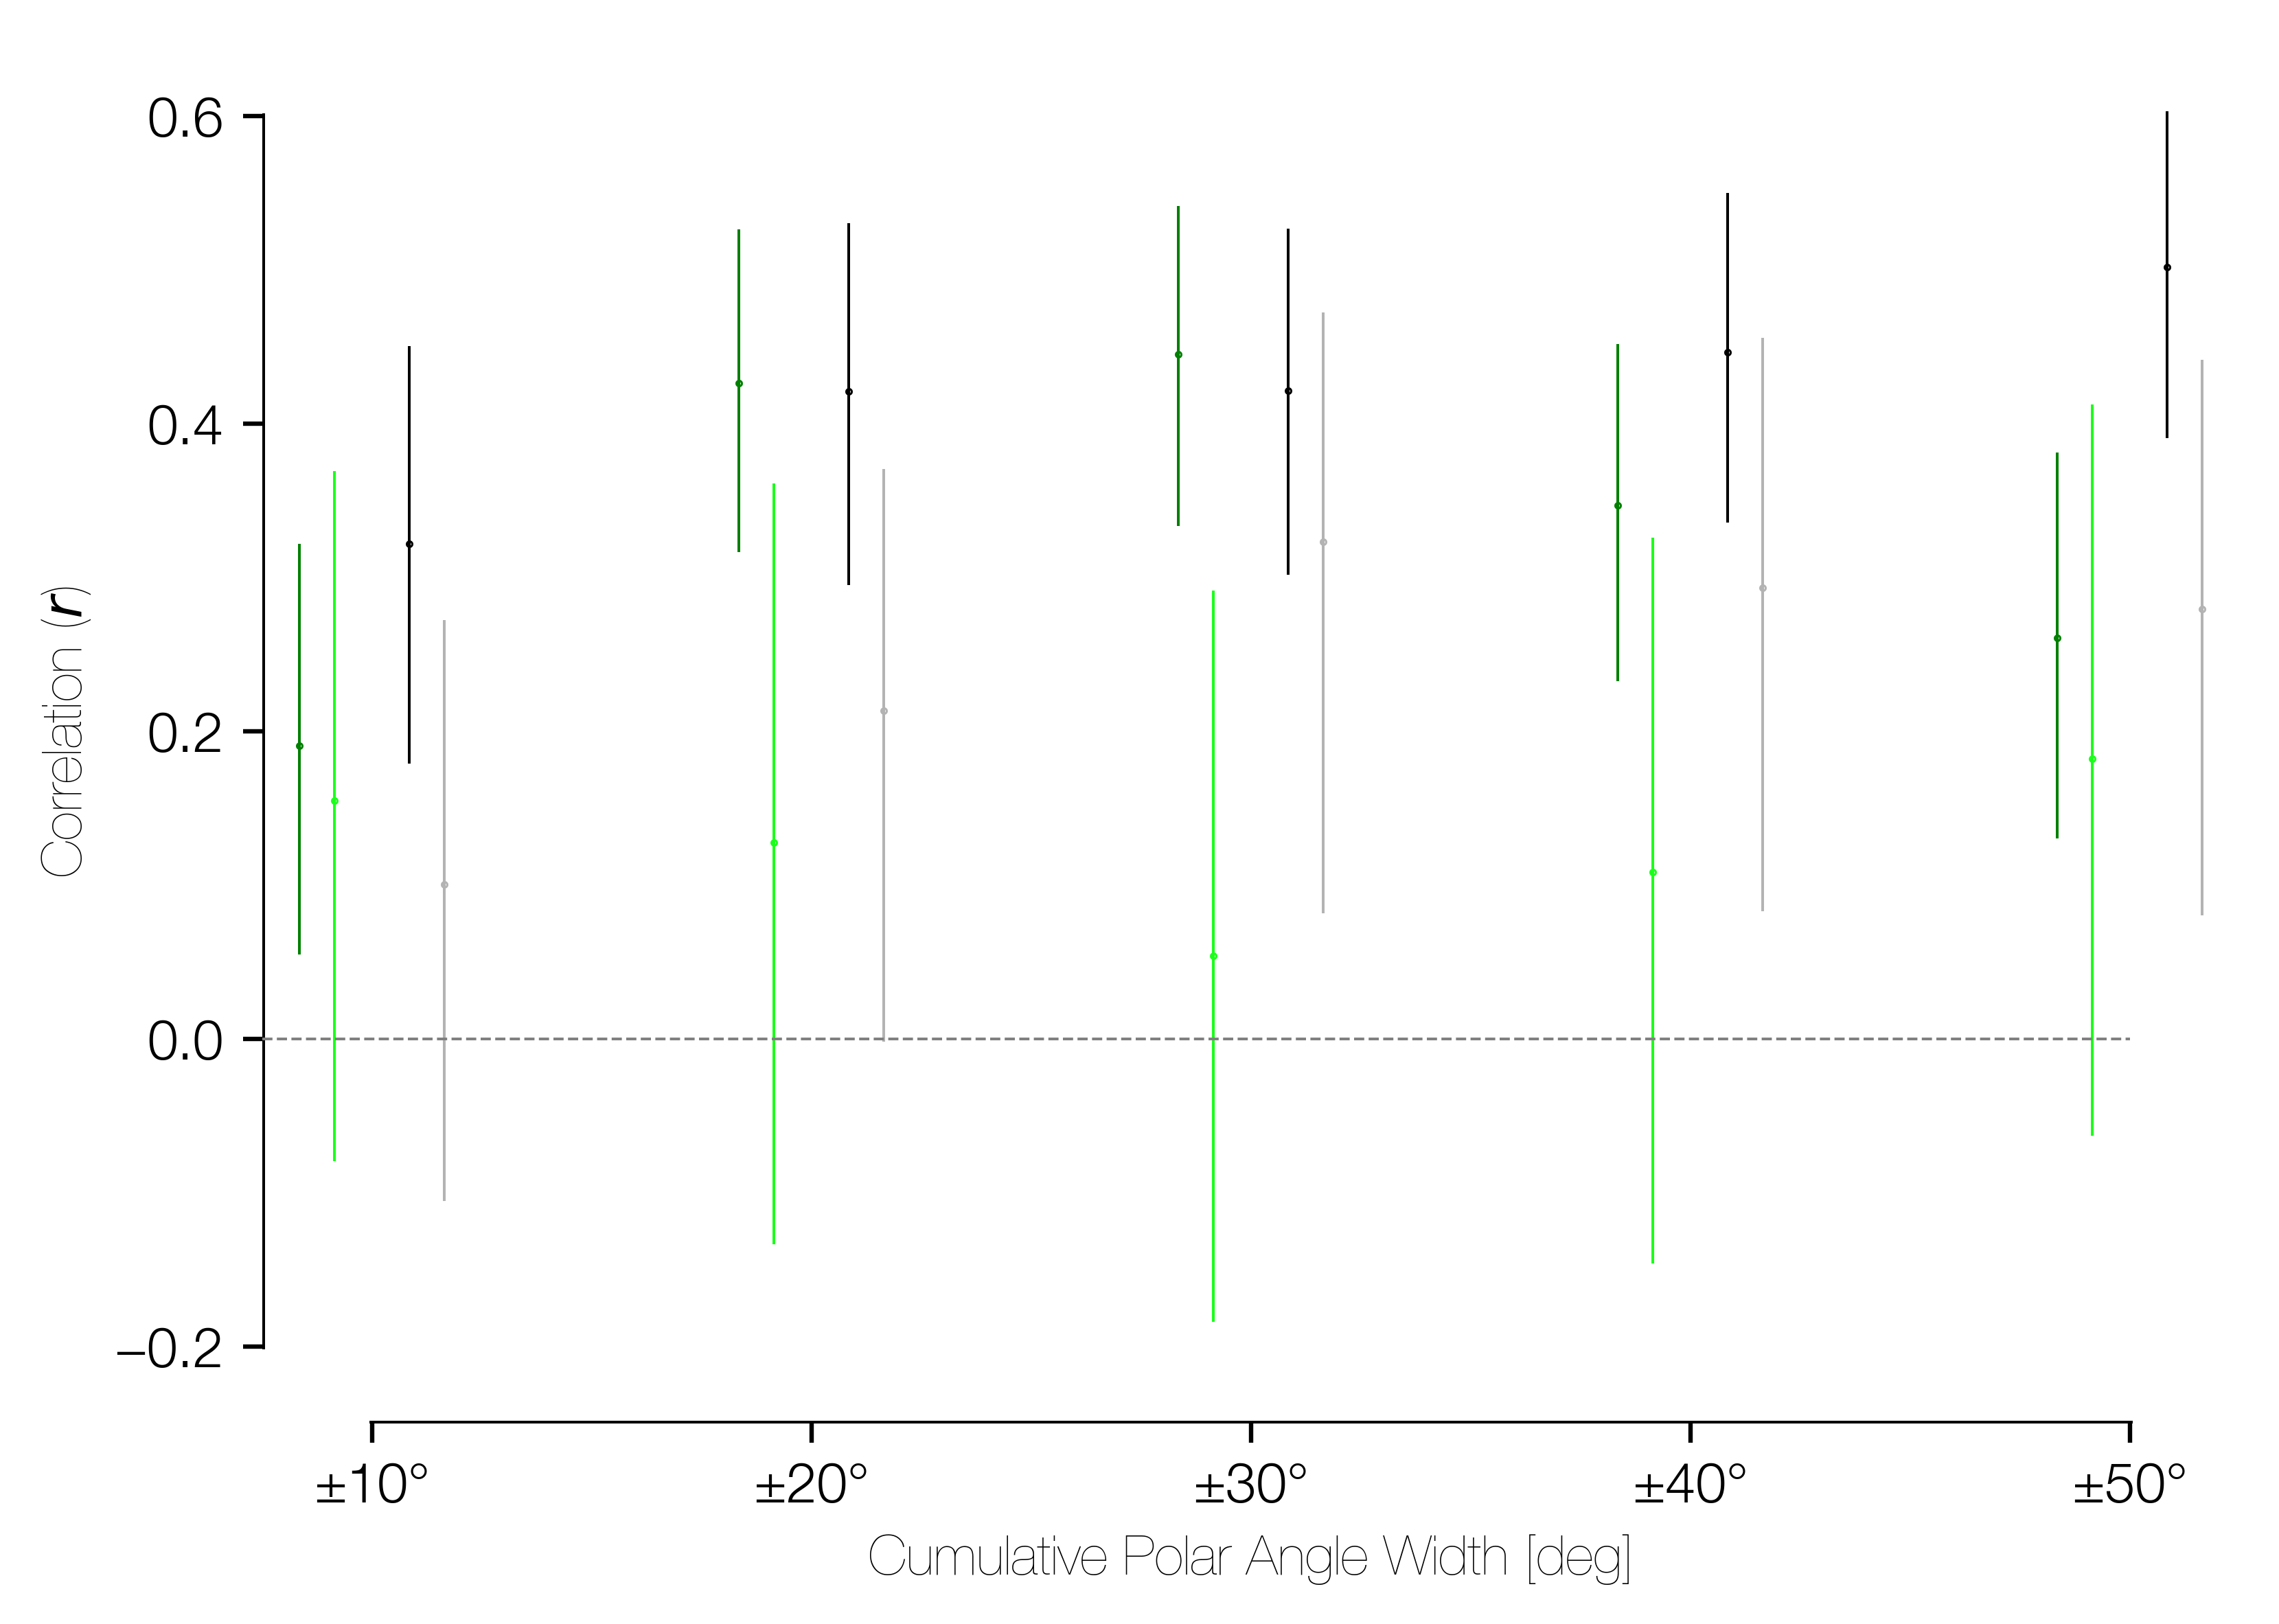

In [105]:
df = pair_data
mz = df.loc[df['relationship'] == 'MZ']
dz = df.loc[df['relationship'] == 'DZ']

(fig,ax) = plt.subplots(1,1, figsize=(5, 3.5), dpi=72*8)
fig.subplots_adjust(0,0,1,1,0,0)

colors = [[(0,0.5,0), (0.1,1,0.1)], # HVA MZ, HVA DZ
          [(0,0,0), (0.7,0.7,0.7)]] # VMA MZ, VMA DZ
for (q, clrs, dx1) in zip(['HVA', 'VMA'], colors, [-0.125, 0.125]):
    for (df, c, dx2) in zip([mz,dz], clrs, [-0.04, 0.04]):
        for (w,x0) in zip([10,20,30,40,50], [0,1,2,3,4]):
            u1 = df['%s%d_1' % (q, w)].values
            u2 = df['%s%d_2' % (q, w)].values
            (lb, md, ub) = icc(u1, u2, bootstraps=10000, confidence=68)
            x = x0 + dx1 + dx2
            ax.plot([x, x], [lb, ub], '-', c=c, lw=0.5)
            ax.plot(x, md, '.', c=c, ms=0.75)

redraw_axes(ax, [-0.25, 4.25], [-0.25, 0.65], [0,1,2,3,4], [-0.2, 0, 0.2, 0.4, 0.6])
ax.plot([-0.25, 4], [0, 0], '--', c=(0.5,0.5,0.5), lw=0.5)
#ax.plot([0.5, 0.5], [-0.6, 0.6], ':', c=(0.25,0.25,0.25), lw=0.5)
ax.set_xticklabels(['±10°', '±20°', '±30°', '±40°', '±50°'])
ax.set_xlabel('Cumulative Polar Angle Width [deg]')
ax.set_ylabel(r'Correlation ($r$)')

plt.savefig('/home/nben/tmp/tmp.pdf', bbox_inches='tight')